<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2025<br>
<font color=3C99D size=5>
      Financial Text Sentiment Analysis
</div>
<div dir=ltr align=center>
<font color=0CBCDF size=4>
    Faraz Doagooye Tehrani, Amir Parsa Safari, Hosna Shahheidari
<br>
<font color=0CBCDF size=4>
</div>

____

# PART ONE

---

# Part 1 — Data Preparation & Preprocessing

This section prepares the **Financial PhraseBank** dataset for a Transformer-based sentiment classifier.

**Goal:** load and merge the dataset files, explore label distribution, clean/prepare text + labels, split into train/validation, and build PyTorch `Dataset` + `DataLoader` objects using a **BERT tokenizer** (token IDs + attention masks).

---

## 1.1 Load & Merge Dataset

**What we do**
- Download / unzip the Financial PhraseBank dataset (ZIP).
- Read all text files inside the dataset directory.
- Merge the content into a single `DataFrame` with at least:
  - `sentence`: input text
  - `label`: sentiment label (`positive`, `negative`, `neutral`)
- Plot the class distribution.

**Why it matters**
- PhraseBank is provided as multiple files (different agreement levels).
- Having one unified `DataFrame` makes preprocessing and experiments reproducible.

**Expected output**
- A `DataFrame` containing all examples.
- A bar chart showing class counts (expect many Neutral samples).

---

## 1.2 Preprocess + Train/Validation Split

**What we do**
- Clean and normalize text (light preprocessing recommended).
- Convert labels from strings to integer indices:
  - `negative → 0`
  - `neutral → 1`
  - `positive → 2`
- Perform an **80/20** split into train/validation using a **stratified split** (preserving class ratio).

**Why it matters**
- Consistent label mapping avoids evaluation mistakes.
- Stratification is important because the dataset is imbalanced (Neutral dominates).

**Expected output**
- `train_df` and `val_df` with correct columns:
  - `sentence`, `label_idx`
  - optional: `weight` (agreement weight per sample)
- Verified split ratio and class distributions for both splits.

---

## 1.3 PyTorch Dataset + DataLoaders with BERT Tokenizer

**What we do**
- Implement `FinancialDataset` to return:
  - `input_ids`
  - `attention_mask`
  - `labels`
  - optional: `weights` (for agreement weighting)
- Create `DataLoader`s:
  - `train_loader`
  - `val_loader`
- Optionally handle class imbalance using:
  - `WeightedRandomSampler` for training (recommended for macro-F1)

**Why it matters**
- Tokenization converts text to fixed-length tensors that a Transformer can process.
- Attention masks ensure the model ignores padding tokens.

**Expected output**
- Working `train_loader` and `val_loader` that yield batches with:
  - `(batch_size, max_len)` for `input_ids` and `attention_mask`
  - `(batch_size,)` for `labels` (and `weights` if used)

---

## Notes & Common Pitfalls

- **Imbalance:** Neutral is often the majority → macro-F1 can drop if you don’t correct for it.
- **Tokenizer choice:** Using `bert-base-uncased` tokenizer is allowed (it’s a tokenizer, not a pretrained classifier).
- **Padding:** Always pass `attention_mask` and ignore PAD tokens in pooling/attention.
- **Reproducibility:** set a random seed before splitting/training.

---

✅ After finishing Part 1, we have:
- `train_loader`, `val_loader`
- `tokenizer`, `MAX_LEN`
- label mapping + (optional) agreement weights ready for training

<font color=FF8C00 size=6>
Attention </font>

Set the colab boolean in the cell below to True if you are using google colab.

In [1]:
colab = True

In [2]:
import zipfile
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math
from transformers import BertTokenizer
import copy
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from sklearn.metrics import f1_score

In [3]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
if colab:
    zip_path = '/content/drive/MyDrive/data/FinancialPhraseBank-v1.0.zip'
    extract_path = '/content/financial_data/FinancialPhraseBank-v1.0/'
else:
    zip_path = 'FinancialPhraseBank-v1.0.zip'
    extract_path = 'financial_data/'

if not os.path.exists(extract_path):
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Files extracted successfully!")
    else:
        print(f"Error: {zip_path} not found! Please move the zip file to: {os.getcwd()}")

data_file_allagree = os.path.join(extract_path , 'FinancialPhraseBank-v1.0/Sentences_AllAgree.txt')
df_allagree = pd.read_csv(data_file_allagree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')

print(f"Data ready! Total rows of all agree: {len(df_allagree)}")
df_allagree.head()

Files extracted successfully!
Data ready! Total rows of all agree: 2264


sentence     label
0  According to Gran , the company has no plans t...   neutral
1  For the last quarter of 2010 , Componenta 's n...  positive
2  In the third quarter of 2010 , net sales incre...  positive
3  Operating profit rose to EUR 13.1 mn from EUR ...  positive
4  Operating profit totalled EUR 21.1 mn , up fro...  positive

In [5]:
data_file_75agree = os.path.join(extract_path, 'FinancialPhraseBank-v1.0/Sentences_75Agree.txt')
df_75agree = pd.read_csv(data_file_75agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')
data_file_66agree = os.path.join(extract_path, 'FinancialPhraseBank-v1.0/Sentences_66Agree.txt')
df_66agree = pd.read_csv(data_file_66agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')
data_file_50agree = os.path.join(extract_path, 'FinancialPhraseBank-v1.0/Sentences_50Agree.txt')
df_50agree = pd.read_csv(data_file_50agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')


set_all = set(df_allagree['sentence'])
set_75 = set(df_75agree['sentence'])
set_66 = set(df_66agree['sentence'])
set_50 = set(df_50agree['sentence'])

check_1 = set_all.issubset(set_75)
check_2 = set_75.issubset(set_66)
check_3 = set_66.issubset(set_50)

print(f"Is AllAgree inside 75Agree? {check_1}")
print(f"Is 75Agree inside 66Agree? {check_2}")
print(f"Is 66Agree inside 50Agree? {check_3}")

print(f"\nCounts:")
print(f"AllAgree: {len(set_all)}")
print(f"75Agree:  {len(set_75)}")
print(f"66Agree:  {len(set_66)}")
print(f"50Agree:  {len(set_50)}")

Is AllAgree inside 75Agree? True
Is 75Agree inside 66Agree? True
Is 66Agree inside 50Agree? True

Counts:
AllAgree: 2259
75Agree:  3448
66Agree:  4211
50Agree:  4838


In [6]:
df_final = df_50agree.copy()

def assign_weight(sentence):
    if sentence in set_all:
        return 1.3
    elif sentence in set_75:
        return 1.1
    elif sentence in set_66:
        return 1.0
    else:
        return 0.9

df_final['weight'] = df_final['sentence'].apply(assign_weight)

print(df_final['weight'].value_counts())

weight
1.3    2264
1.1    1190
1.0     765
0.9     627
Name: count, dtype: int64


<font color=3C99D size=5>
Conclusion: </font>

Since the set of 50 agree is the most general one we will train on that and based on how sure they are, we gave them a weight and then in the loss function, we included them with that weight.

In [7]:
df = df_final

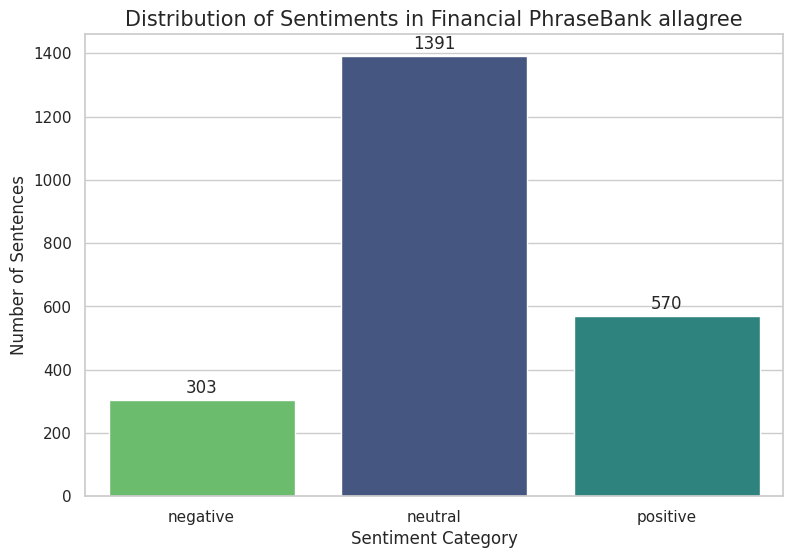

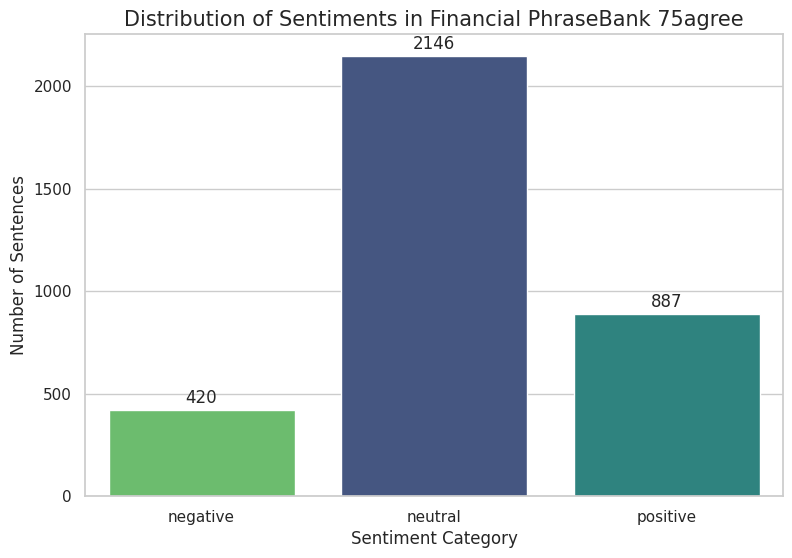

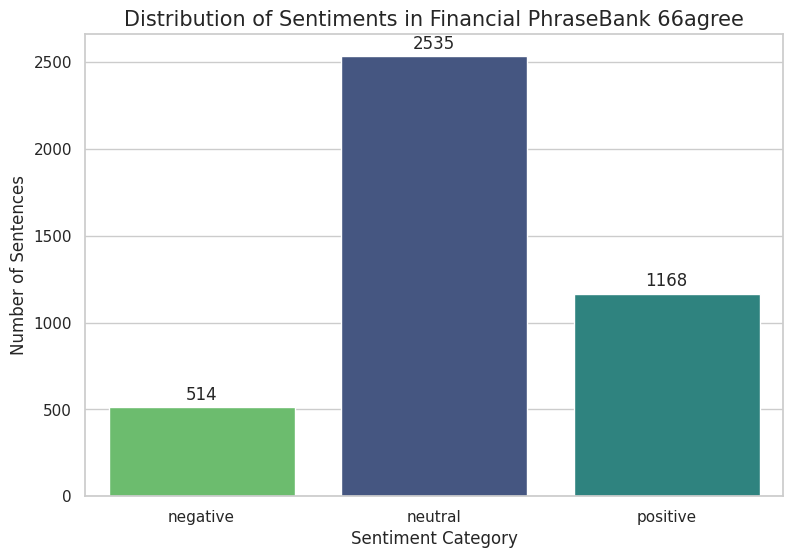

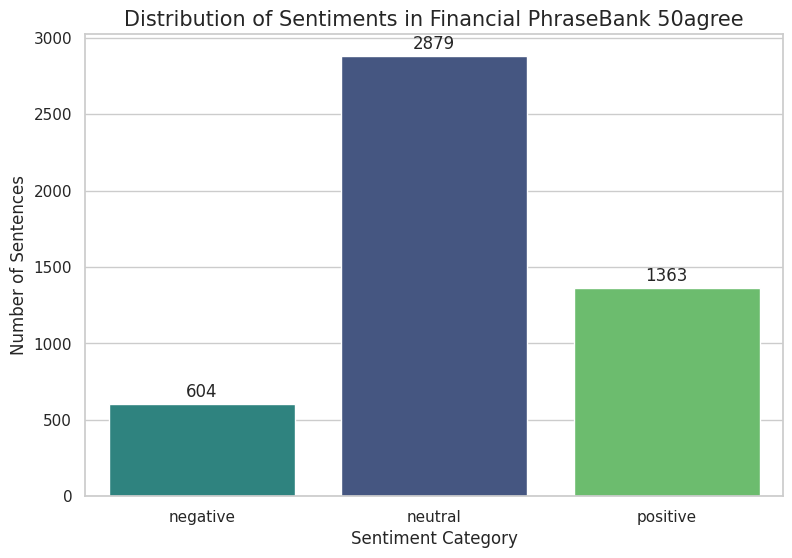

In [8]:
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df_allagree, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank allagree', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df_75agree, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank 75agree', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df_66agree, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank 66agree', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df_50agree, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank 50agree', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

In [9]:
label_encoder = LabelEncoder() #turning labels to numbers
df['label_idx'] = label_encoder.fit_transform(df['label'])

class_names = label_encoder.classes_
print(f"Mapping: {dict(zip(range(len(class_names)), class_names))}")

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_idx']
)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}
Train size: 3876, Validation size: 970


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

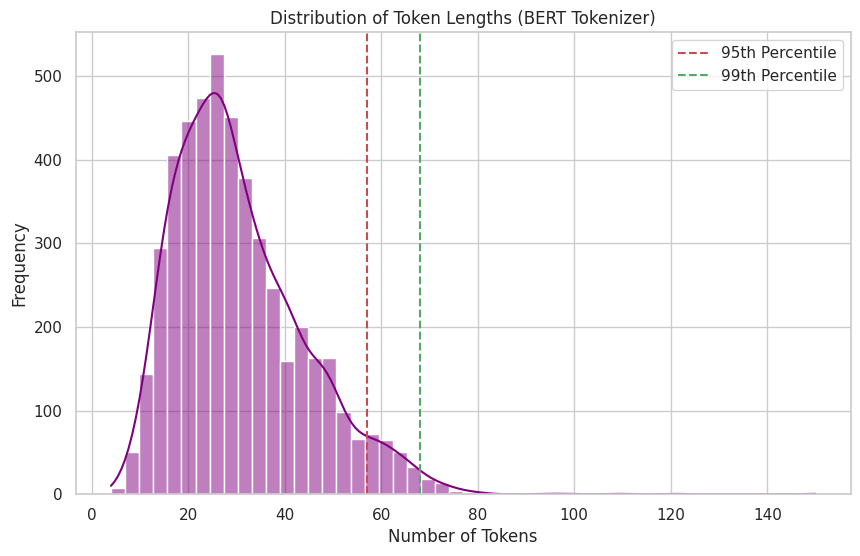

95% Percentile: 57.0
99% Percentile: 68.0
Max Length: 150


In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df['token_lengths'] = [len(tokenizer.encode(s, add_special_tokens=True)) for s in df['sentence']]

plt.figure(figsize=(10, 6))
sns.histplot(df['token_lengths'], bins=50, kde=True, color='purple')
plt.title('Distribution of Token Lengths (BERT Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.axvline(x=df['token_lengths'].quantile(0.95), color='r', linestyle='--', label='95th Percentile')
plt.axvline(x=df['token_lengths'].quantile(0.99), color='g', linestyle='--', label='99th Percentile')
plt.legend()
plt.show()

print(f"95% Percentile: {df['token_lengths'].quantile(0.95)}")
print(f"99% Percentile: {df['token_lengths'].quantile(0.99)}")
print(f"Max Length: {df['token_lengths'].max()}")

<font color=3C99D size=5>
Conclusion: </font>

Since only less than one percent of the sentences have more than 68 tokens, choosing 80 tokens as the max length is a good number



In [11]:
class FinancialDataset(Dataset):
    def __init__(self, sentences, labels, weights, tokenizer, max_len=80):
        self.sentences = sentences.values
        self.labels = labels.values
        self.weights = weights.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = str(self.sentences[item])
        label = self.labels[item]
        weight = self.weights[item]

        encoding = self.tokenizer(
            sentence,
            add_special_tokens=True,  #Added [CLS], [SEP]
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'weights': torch.tensor(weight, dtype=torch.float)
        }

In [12]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# If you run the notebook top-to-bottom, MAX_LEN and use_weighted_sampler may not be defined yet.
# Use safe defaults here; later, if you change MAX_LEN, re-run this cell.
dataset_max_len = globals().get('MAX_LEN', 80)
use_weighted_sampler_local = globals().get('use_weighted_sampler', True)

train_dataset = FinancialDataset(train_df['sentence'], train_df['label_idx'], train_df['weight'], tokenizer, max_len=dataset_max_len)
val_dataset = FinancialDataset(val_df['sentence'], val_df['label_idx'], val_df['weight'], tokenizer, max_len=dataset_max_len)

BATCH_SIZE = 32

# ---- class imbalance handling (recommended for macro-F1) ----
from torch.utils.data import WeightedRandomSampler

if use_weighted_sampler_local:
    # inverse-frequency sampling so minority classes appear more often per minibatch
    class_counts = train_df['label_idx'].value_counts().sort_index()
    inv_freq = (1.0 / class_counts).to_dict()
    sample_weights = train_df['label_idx'].map(inv_freq).values.astype('float64')
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
else:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('Train batches:', len(train_loader), 'Val batches:', len(val_loader), '| max_len:', dataset_max_len)


Train batches: 122 Val batches: 31 | max_len: 80


In [ ]:

# Optional: trim padded sequences to the maximum *real* length in each batch.
# This keeps your Dataset unchanged (still pads to MAX_LEN), but reduces wasted computation
# and can slightly improve generalization on small datasets.
#
# Toggle with: use_batch_trimming (set in the config cell).

from torch.utils.data import DataLoader, WeightedRandomSampler

def trim_collate(batch):
    # batch: list[dict]
    input_ids = torch.stack([b["input_ids"] for b in batch], dim=0)
    attention_mask = torch.stack([b["attention_mask"] for b in batch], dim=0)
    labels = torch.stack([b["labels"] for b in batch], dim=0)
    weights = torch.stack([b["weights"] for b in batch], dim=0)

    # max number of non-pad tokens in this batch
    max_len = int(attention_mask.sum(dim=1).max().item())
    max_len = max(2, max_len)

    input_ids = input_ids[:, :max_len]
    attention_mask = attention_mask[:, :max_len]

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
        "weights": weights,
    }

# Rebuild loaders with trim_collate if enabled
if globals().get("use_batch_trimming", False):
    use_weighted_sampler_local = globals().get('use_weighted_sampler', True)

    if use_weighted_sampler_local:
        class_counts = train_df['label_idx'].value_counts().sort_index()
        inv_freq = (1.0 / class_counts).to_dict()
        sample_weights = train_df['label_idx'].map(inv_freq).values.astype('float64')
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, collate_fn=trim_collate)
    else:
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=trim_collate)

    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=trim_collate)
    print("Batch trimming enabled → loaders rebuilt with trim_collate().")
else:
    print("Batch trimming disabled → using original loaders.")


# PART TWO

---

# Part 2 — Build the Transformer Model From Scratch

In this section we implement a **Transformer encoder** for 3-class financial sentiment classification **without using high-level ready-made Transformer modules** (e.g., no `nn.MultiheadAttention`, no pretrained BERT model classes).  
We implement the core building blocks manually using PyTorch tensor operations (`matmul`, `einsum`, masking, etc.).

**Goal:** create a complete model:
- token + positional embeddings
- stacked Transformer blocks (Self-Attention + FFN + Residuals + LayerNorm)
- final classifier head for **3 classes**: Negative, Neutral, Positive

---

## 2.1 Self-Attention

### What we implement
We implement a `SelfAttention` module that computes:

- Queries, Keys, Values:
\[
Q = XW_Q,\quad K = XW_K,\quad V = XW_V
\]

- Scaled dot-product attention:
\[
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\]

### Multi-Head Attention
We split the model dimension into multiple heads:

- `d_model = num_heads * head_dim`
- Each head computes its own attention, then we concatenate and project back.

### Masking
We apply an **attention mask** so padding tokens do not influence attention scores:
- padded positions receive a large negative value before softmax (e.g., `-1e9`).

### Expected output
- A correct `(B, T, d_model)` output tensor.
- Optional: storing attention weights for visualization in Part 6.

---

## 2.2 Transformer Block (15 points)

A Transformer encoder block contains:

1) **Self-Attention sub-layer**
2) **Feed-Forward Network (FFN)**
3) **Residual connections**
4) **Layer normalization**
5) **Dropout**

### Pre-Norm architecture (recommended)
We use Pre-LayerNorm for stable training from scratch:

$
X = X + \text{Attention}(\text{LayerNorm}(X))
$
$
X = X + \text{FFN}(\text{LayerNorm}(X))
$

### Feed-Forward Network (FFN)
A standard FFN:
$
\text{FFN}(x) = W_2 \cdot \sigma(W_1 x + b_1) + b_2
$
with:
- hidden size = `ff_hidden_dim` (often `2x–4x d_model`)
- activation = **GELU** (common in Transformers)

### Expected output
- A reusable `TransformerBlock` module that preserves shape `(B, T, d_model)`.

---

## 2.3 Full Model: FinancialTransformer (15 points)

### Architecture overview
The full classifier model has:

1) **Token embedding**
2) **Positional embedding**
3) **Stack of Transformer blocks** (`NUM_LAYERS`)
4) **Pooling layer** to convert sequence → single vector
5) **Classifier head** producing logits of shape `(B, 3)`

### Embeddings
- Token embeddings convert IDs → vectors.
- Positional embeddings encode word order.

Optional but recommended:
- set `padding_idx` in embeddings so PAD tokens do not learn random embeddings.

### Pooling strategy
We convert `(B, T, d_model)` to `(B, d_model)` using one of:
- **Mean pooling (masked)** — often best when training from scratch
- **CLS pooling** — often better for pretrained models

### Classifier head
A small MLP or Linear layer mapping:
$
(B, d_model) \rightarrow (B, 3)
$

### Expected output
- A `FinancialTransformer` model that takes:
  - `input_ids`, `attention_mask`
- Outputs:
  - `logits` (for cross-entropy loss)
  - optionally attention weights (for Part 6)

---

## Notes & Common Pitfalls

- **Shape errors:** ensure reshaping across heads is correct.
- **Masking:** masks must broadcast correctly to attention score shape.
- **Head dimension:** `d_model % num_heads == 0` must hold.
- **Dropout:** apply to attention weights and/or FFN output to reduce overfitting.
- **Stability:** Pre-Norm blocks + gradient clipping typically train better from scratch.

---

After finishing Part 2, we have:
- `SelfAttention`
- `TransformerBlock`
- `FinancialTransformer` (end-to-end classifier)
- Model outputs of shape `(batch_size, 3)` ready for training in Part 3

In [13]:
# Training configuration (tune these!)
dropout_val = 0.2
learning_rate = 3e-4          # peak LR (used by warmup/inv-sqrt schedule)
weight_decay = 0.01           # AdamW decoupled weight decay
epochs = 20
warmup_ratio = 0.10           # 10% of total steps
grad_clip_norm = 1.0

# Imbalance + robustness options
use_weighted_sampler = True   # balances minibatches (recommended for macro-F1)
use_class_weights_in_loss = False  # usually keep False when sampler=True (avoid double-compensation)
use_agreement_weights = True  # uses df_final['weight'] (agreement-based) as per-example weights


# Advanced (no-pretraining) options to push Macro-F1
# - 'cb_focal' often improves minority-class recall (positive/negative) vs standard CE
# - R-Drop adds consistency regularization (2 forward passes with dropout)
loss_name = "cb_focal"        # options: "ce", "cb_focal"
cb_beta = 0.999               # class-balanced beta (close to 1.0)
focal_gamma = 2.0             # focal gamma (1.5–2.5 typical)

use_rdrop = True              # doubles forward passes; turn off if slow
rdrop_alpha = 2.0             # strength of KL consistency term (1–4 typical)

agreement_weight_power = 2.0  # >1 makes low-agreement examples contribute less (e.g., 50% -> 0.25)
use_batch_trimming = True     # trims padded length per-batch (faster; often slightly better)

label_smoothing = 0.05        # small smoothing helps with noisy labels (especially 50Agree)

# Pooling: 'mean' is often better than 'cls' when training from scratch
pooling = "mean"              # options: "mean", "cls"

# Model size (smaller than BERT is usually better from scratch on ~5k samples)
D_MODEL = 256                 # must be divisible by NUM_HEADS
NUM_HEADS = 4
NUM_LAYERS = 3
FF_HIDDEN_DIM = 4 * D_MODEL
MAX_LEN = 80
NUM_CLASSES = 3

print("Config ready.")


Config ready.


In [14]:
class MultiHeadAttention(nn.Module):
    # From-scratch multi-head self-attention (no nn.MultiheadAttention).
    # Supports:
    #   - padding mask (shape [B, S] or broadcastable to [B, 1, 1, S])
    #   - attention dropout
    #   - optional storing of last attention weights for visualization

    def __init__(self, d_model, num_heads, attn_dropout=0.1, store_attention=False):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model, bias=True)
        self.W_k = nn.Linear(d_model, d_model, bias=True)
        self.W_v = nn.Linear(d_model, d_model, bias=True)
        self.W_o = nn.Linear(d_model, d_model, bias=True)

        self.attn_dropout = nn.Dropout(attn_dropout)
        self.store_attention = store_attention
        self.last_attention_weights = None  # (B, H, S, S) when enabled

    def _shape(self, x, batch_size):
        # (B, S, D) -> (B, H, S, d_k)
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def forward(self, q, k, v, mask=None):
        # q,k,v: (B, S, D)
        # mask:
        #   - (B, S) attention_mask with 1 for tokens, 0 for padding
        #   - or (B, 1, 1, S) broadcastable mask
        batch_size, seq_len, _ = q.size()

        Q = self._shape(self.W_q(q), batch_size)
        K = self._shape(self.W_k(k), batch_size)
        V = self._shape(self.W_v(v), batch_size)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)  # (B, H, S, S)

        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1).unsqueeze(2)  # (B, 1, 1, S)
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)

        if self.store_attention:
            self.last_attention_weights = attn_weights.detach()  # keep on device

        out = torch.matmul(attn_weights, V)  # (B, H, S, d_k)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)  # (B, S, D)
        return self.W_o(out)


In [15]:
class TransformerBlock(nn.Module):
    # Encoder block with Pre-LayerNorm (more stable training from scratch).
    def __init__(self, d_model, num_heads, ff_hidden_dim, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_model=d_model,
            num_heads=num_heads,
            attn_dropout=dropout,
            store_attention=False,
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_hidden_dim, d_model),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Pre-LN attention
        x_norm = self.norm1(x)
        attn_out = self.attention(x_norm, x_norm, x_norm, mask)
        x = x + self.dropout(attn_out)

        # Pre-LN FFN
        x_norm = self.norm2(x)
        ffn_out = self.ffn(x_norm)
        x = x + self.dropout(ffn_out)
        return x


In [16]:
class FinancialTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model,
        num_heads,
        num_layers,
        ff_hidden_dim,
        max_len,
        num_classes=3,
        dropout=0.1,
        pad_token_id=0,
        pooling="mean",
    ):
        super().__init__()
        self.d_model = d_model
        self.pooling = pooling
        self.pad_token_id = pad_token_id

        # padding_idx keeps the PAD embedding at zero and prevents it from updating
        self.token_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_token_id)

        # Sinusoidal positional encoding (fixed)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("positional_encoding", pe.unsqueeze(0), persistent=False)

        self.layers = nn.ModuleList(
            [TransformerBlock(d_model, num_heads, ff_hidden_dim, dropout) for _ in range(num_layers)]
        )

        self.final_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes),
        )

    def set_store_attention(self, value: bool = True):
        # Enable/disable saving last-layer attention weights (for visualization)
        for layer in self.layers:
            layer.attention.store_attention = value

    def forward(self, input_ids, attention_mask):
        # input_ids: (B, S), attention_mask: (B, S)
        batch_size, seq_len = input_ids.shape

        # embedding scaling is standard for Transformers
        x = self.token_embedding(input_ids) * math.sqrt(self.d_model)
        x = x + self.positional_encoding[:, :seq_len, :]
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, attention_mask)

        x = self.final_norm(x)

        if self.pooling == "cls":
            pooled = x[:, 0, :]
        else:
            # masked mean pooling
            mask = attention_mask.unsqueeze(-1).float()  # (B, S, 1)
            summed = (x * mask).sum(dim=1)
            denom = mask.sum(dim=1).clamp(min=1e-6)
            pooled = summed / denom

        logits = self.classifier(pooled)
        return logits


In [17]:
VOCAB_SIZE = tokenizer.vocab_size
PAD_TOKEN_ID = tokenizer.pad_token_id

model = FinancialTransformer(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    ff_hidden_dim=FF_HIDDEN_DIM,
    max_len=MAX_LEN,
    num_classes=NUM_CLASSES,
    dropout=dropout_val,
    pad_token_id=PAD_TOKEN_ID,
    pooling=pooling,
)

print(model)


FinancialTransformer(
  (token_embedding): Embedding(30522, 256, padding_idx=0)
  (layers): ModuleList(
    (0-2): 3 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
        (attn_dropout): Dropout(p=0.2, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (final_norm): LayerNorm((256,), eps=1e-05, el

# PART THREE

---

# Part 3 — Training the Model

In this section we train the `FinancialTransformer` model on the training split and monitor performance on the validation split.

**Goal:** implement a standard training pipeline using:
- optimizer (AdamW recommended)
- appropriate loss (CrossEntropy, optional label smoothing)
- logging of **loss** and **accuracy** for both Train and Validation each epoch
- checkpoint saving / loading and optional fine-tuning

---

## 3.1 Training Loop

### What we do
For each epoch:
1. Set model to `train()` mode.
2. For each minibatch:
   - Move tensors to `device`.
   - Forward pass to compute logits.
   - Compute the loss.
   - Backpropagation (`loss.backward()`).
   - Apply gradient clipping (optional but recommended).
   - Optimizer step.
   - Zero gradients.

### Loss function
We use multi-class cross entropy:

\[
\mathcal{L} = -\sum_{c=1}^{3} y_c \log p_c
\]

Optional improvements:
- **label smoothing** (helps with noisy labels in PhraseBank):
  - encourages less overconfident predictions

### Handling imbalance (recommended for macro-F1)
Because Neutral dominates, we typically apply at least one of:
- `WeightedRandomSampler` to rebalance batches
- class weights in the loss
- (optional) agreement weights if the dataset includes agreement level metadata

If we use agreement weights, we must compute per-sample losses:
- `CrossEntropyLoss(reduction="none")`
- then multiply each sample’s loss by its agreement weight before averaging

---

## 3.2 Monitoring: Loss & Accuracy Curves

### What we log
At the end of every epoch:
- `train_loss`, `train_accuracy`
- `val_loss`, `val_accuracy`

These are stored in a `history` dictionary so we can:
- plot learning curves
- diagnose underfitting vs overfitting
- track the best epoch

### Why accuracy is not enough
Because this is imbalanced, accuracy can look good even if the model ignores minority classes.  
Later in Part 4 we use macro/weighted metrics (Precision/Recall/F1) for a more reliable evaluation.

---

## Checkpointing

We save a checkpoint containing:
- `model_state_dict`
- `history`
- `epoch`
- training configuration (hyperparameters)

This allows:
- resuming training
- reproducing results
- running fine-tuning from the best weights

---

## Fine-tuning from a Loaded Checkpoint

After loading a checkpoint, we can continue training for a small number of epochs using:
- a **smaller learning rate** (e.g., `0.25 * original_lr`)
- the same preprocessing + model architecture

Fine-tuning is useful when:
- you found good hyperparameters
- the model is improving slowly
- you want to squeeze out extra macro-F1 without overfitting

---

## Notes & Common Pitfalls

- **Always call `model.train()` and `model.eval()`** in the right places.
- **Don’t forget `torch.no_grad()`** for validation to save memory and speed.
- **Use gradient clipping** to avoid exploding gradients in attention models.
- **Warmup + LR schedule** can stabilize training early when training from scratch.
- **Imbalance matters:** macro-F1 usually improves noticeably with balanced sampling.

---

After finishing Part 3, we have:
- a trained model
- training/validation curves (loss & accuracy)
- a saved checkpoint
- ability to load checkpoint and fine-tune if desired

## Extra options to improve Macro-F1 (no pretraining)

If you are stuck around **0.68–0.70 macro-F1**, the biggest gains usually come from **changing the objective** and **regularizing** for small / noisy data:

- **CB-Focal loss** (`loss_name="cb_focal"`): improves minority-class recall (Positive/Negative) on imbalanced data.
- **R-Drop** (`use_rdrop=True`): runs the model twice with dropout and adds a consistency (KL) penalty.
- **Agreement sharpening** (`agreement_weight_power>1`): makes low-agreement examples contribute less.
- **Batch trimming** (`use_batch_trimming=True`): trims padded length per batch (faster, sometimes slightly better).

All of these are implemented in this notebook without using pretrained embeddings/models.


In [18]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Device set to: Apple MPS (GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Device set to: NVIDIA CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("Device set to: CPU")

if colab:
      path = '/content/drive/MyDrive/data/checkpoint.pth'
else:
      path = 'checkpoint.pth'

model.to(device)


Device set to: NVIDIA CUDA (GPU)


FinancialTransformer(
  (token_embedding): Embedding(30522, 256, padding_idx=0)
  (layers): ModuleList(
    (0-2): 3 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
        (attn_dropout): Dropout(p=0.2, inplace=False)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (final_norm): LayerNorm((256,), eps=1e-05, el

In [19]:
# Loss function
# - reduction='none' is required for correct per-example weighting
# - label_smoothing can help on noisy labels
#
# Note: if you enable sampler balancing, usually keep use_class_weights_in_loss=False.

if use_class_weights_in_loss:
    labels = train_df['label_idx'].values
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
else:
    class_weights = None

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    reduction='none',
    label_smoothing=label_smoothing
)


In [ ]:
# -------------------------------
# Advanced (no-pretraining) tricks
# 1) Class-Balanced Focal Loss (CB-Focal)  → improves minority recall → higher macro-F1
# 2) R-Drop regularization               → consistency regularization for small/noisy datasets
# 3) Sharpen agreement weights           → reduce influence of ambiguous (low-agreement) labels
# -------------------------------

import torch.nn.functional as F

class CBFocalLoss(nn.Module):
    """
    Class-Balanced Focal Loss for multi-class classification.
    alpha is computed from class counts using 'effective number of samples':
        alpha_c ∝ (1 - beta) / (1 - beta^{n_c})
    """
    def __init__(self, class_counts, beta=0.999, gamma=2.0, reduction="none"):
        super().__init__()
        counts = torch.tensor(class_counts, dtype=torch.float)

        beta_t = torch.tensor(beta, dtype=torch.float)
        effective_num = 1.0 - torch.pow(beta_t, counts)
        alpha = (1.0 - beta_t) / (effective_num + 1e-12)

        # Normalize so sum(alpha) == num_classes
        alpha = alpha / alpha.sum() * len(class_counts)
        self.register_buffer("alpha", alpha)
        self.gamma = float(gamma)
        self.reduction = reduction

    def forward(self, logits, targets):
        # logits: (B,C), targets: (B,)
        log_probs = F.log_softmax(logits, dim=-1)
        probs = torch.exp(log_probs)

        targets = targets.long()
        idx = torch.arange(logits.size(0), device=logits.device)
        pt = probs[idx, targets]
        log_pt = log_probs[idx, targets]

        at = self.alpha[targets]
        loss = -at * ((1.0 - pt) ** self.gamma) * log_pt  # (B,)

        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss  # "none"

# Instantiate CB-Focal loss using train distribution
_class_counts = train_df["label_idx"].value_counts().sort_index().tolist()
criterion_cb_focal = CBFocalLoss(_class_counts, beta=cb_beta, gamma=focal_gamma, reduction="none").to(device)

def compute_per_sample_loss(logits, labels):
    """
    Returns per-sample loss vector (B,).
    loss_name:
      - "ce": uses CrossEntropyLoss (with optional class weights + label smoothing)
      - "cb_focal": uses class-balanced focal loss
    """
    name = globals().get("loss_name", "ce")
    if name == "cb_focal":
        # When using CB-Focal, avoid also using class-weights in CE (double compensation).
        return criterion_cb_focal(logits, labels)
    return criterion(logits, labels)  # criterion is CE with reduction='none'

def symmetric_kl(logits1, logits2):
    """
    Symmetric KL divergence between two categorical distributions (per sample).
    Returns shape (B,).
    """
    p1 = F.log_softmax(logits1, dim=-1)
    p2 = F.log_softmax(logits2, dim=-1)

    kl12 = F.kl_div(p1, p2.exp(), reduction="none").sum(dim=-1)
    kl21 = F.kl_div(p2, p1.exp(), reduction="none").sum(dim=-1)
    return 0.5 * (kl12 + kl21)


<font color=DC143C size=6>
Warning </font>

Only set the train boolean in the cell below to True if you want to train and else set it to False.

In [20]:
train = True

In [21]:
from sklearn.metrics import f1_score

def evaluate_model(model, data_loader):
    model.to(device)
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_items = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            losses = compute_per_sample_loss(logits, labels)  # (B,)
            loss = losses.mean()

            total_loss += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=1)

            total_correct += (preds == labels).sum().item()
            total_items += labels.size(0)

            all_preds.extend(preds.detach().cpu().tolist())
            all_labels.extend(labels.detach().cpu().tolist())

    avg_loss = total_loss / max(1, total_items)
    avg_acc = total_correct / max(1, total_items)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, avg_acc, macro_f1


In [22]:
from tqdm.auto import tqdm

def build_optimizer_and_scheduler(model, train_loader, epochs):
    # AdamW with decoupled weight decay; don't decay bias/LayerNorm weights
    no_decay = ('bias', 'LayerNorm.weight', 'LayerNorm.bias', 'norm1', 'norm2', 'final_norm')

    decay_params, nodecay_params = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if any(nd in n for nd in no_decay):
            nodecay_params.append(p)
        else:
            decay_params.append(p)

    optimizer = torch.optim.AdamW(
        [{'params': decay_params, 'weight_decay': weight_decay},
         {'params': nodecay_params, 'weight_decay': 0.0}],
        lr=learning_rate,
        betas=(0.9, 0.98),
        eps=1e-9
    )

    total_steps = epochs * len(train_loader)
    warmup_steps = max(1, int(warmup_ratio * total_steps))

    # Warmup + inverse-sqrt decay
    def lr_lambda(step):
        step = max(1, step)
        if step <= warmup_steps:
            return step / warmup_steps
        return (warmup_steps ** 0.5) / (step ** 0.5)

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    return optimizer, scheduler

def train_model(model, train_loader, val_loader, epochs=epochs):
    model.to(device)

    optimizer, scheduler = build_optimizer_and_scheduler(model, train_loader, epochs)

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_macro_f1': [],
        'lr': [],
    }

    best_val_f1 = -1.0
    best_model_wts = copy.deepcopy(model.state_dict())

    patience = 5
    patience_counter = 0
    global_step = 0

    for epoch in range(epochs):
        model.train()
        model.set_store_attention(False)

        running_loss = 0.0
        running_correct = 0
        running_items = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            if use_agreement_weights:
                w = batch['weights'].to(device).float()

                # Normalize to mean=1, then optionally sharpen (power>1 reduces low-agreement influence)
                w = w / w.mean().clamp(min=1e-6)
                power = float(globals().get('agreement_weight_power', 1.0))
                if power != 1.0:
                    w = w.clamp(min=0.0).pow(power)
                    w = w / w.mean().clamp(min=1e-6)
            else:
                w = None

            optimizer.zero_grad(set_to_none=True)

            # Forward + loss (supports CE / CB-Focal + optional R-Drop)
            if globals().get('use_rdrop', False):
                logits1 = model(input_ids, attention_mask)
                logits2 = model(input_ids, attention_mask)

                loss1 = compute_per_sample_loss(logits1, labels)
                loss2 = compute_per_sample_loss(logits2, labels)
                base = 0.5 * (loss1 + loss2)

                kl = symmetric_kl(logits1, logits2)  # (B,)
                alpha = float(globals().get('rdrop_alpha', 2.0))
                per_sample_losses = base + alpha * kl

                # Use averaged logits for accuracy tracking
                logits = 0.5 * (logits1 + logits2)
            else:
                logits = model(input_ids, attention_mask)
                per_sample_losses = compute_per_sample_loss(logits, labels)  # (B,)

            loss = (per_sample_losses * w).mean() if w is not None else per_sample_losses.mean()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)
            optimizer.step()

            global_step += 1
            scheduler.step()
            history['lr'].append(optimizer.param_groups[0]['lr'])

            running_loss += loss.item() * labels.size(0)
            preds = torch.argmax(logits, dim=1)
            running_correct += (preds == labels).sum().item()
            running_items += labels.size(0)

            pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])

        train_loss = running_loss / max(1, running_items)
        train_acc = running_correct / max(1, running_items)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss, val_acc, val_f1 = evaluate_model(model, val_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_macro_f1'].append(val_f1)

        print(
            f'Epoch {epoch+1}/{epochs} | '
            f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | '
            f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | '
            f'Val Macro-F1: {val_f1:.4f}'
        )

        if val_f1 > best_val_f1 + 1e-4:
            best_val_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping: no improvement in Macro-F1 for {patience} epochs.')
                break

    model.load_state_dict(best_model_wts)
    return history


In [23]:
def plot_results(history):
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(list(epochs_range), history['train_loss'], label='Train Loss')
    plt.plot(list(epochs_range), history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list(epochs_range), history['train_acc'], label='Train Acc')
    plt.plot(list(epochs_range), history['val_acc'], label='Val Acc')
    plt.plot(list(epochs_range), history['val_macro_f1'], label='Val Macro-F1')
    plt.title('Accuracy / Macro-F1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


<font color=DC143C size=6>
Warning </font>

Only set the hyperparameter_tuning boolean in the cell below to True if you want to tune the hyperparameters.

In [24]:
# Optional: hyperparameter tuning (disabled by default)
hyperparameter_tuning = False

tune_epochs = 10



Training with d_model = 128


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0965 Acc: 0.3547 | Val Loss: 1.0471 Acc: 0.5361 | Val Macro-F1: 0.4103


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 1.0324 Acc: 0.4788 | Val Loss: 0.9984 Acc: 0.5361 | Val Macro-F1: 0.4611


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.9522 Acc: 0.5384 | Val Loss: 0.9461 Acc: 0.5701 | Val Macro-F1: 0.4954


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.8824 Acc: 0.5967 | Val Loss: 0.8890 Acc: 0.6155 | Val Macro-F1: 0.5430


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.8213 Acc: 0.6349 | Val Loss: 0.8668 Acc: 0.6278 | Val Macro-F1: 0.5710


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.7529 Acc: 0.6873 | Val Loss: 0.8613 Acc: 0.6289 | Val Macro-F1: 0.5718


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.7205 Acc: 0.6971 | Val Loss: 0.9025 Acc: 0.6165 | Val Macro-F1: 0.5614


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.6879 Acc: 0.7180 | Val Loss: 0.9178 Acc: 0.6134 | Val Macro-F1: 0.5685


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.6756 Acc: 0.7229 | Val Loss: 0.8832 Acc: 0.6268 | Val Macro-F1: 0.5817


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.6289 Acc: 0.7554 | Val Loss: 0.9365 Acc: 0.6175 | Val Macro-F1: 0.5728


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.6134 Acc: 0.7722 | Val Loss: 0.8788 Acc: 0.6330 | Val Macro-F1: 0.5960


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.5960 Acc: 0.7683 | Val Loss: 0.8604 Acc: 0.6680 | Val Macro-F1: 0.6185


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.5562 Acc: 0.8001 | Val Loss: 0.8868 Acc: 0.6639 | Val Macro-F1: 0.6176


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.5517 Acc: 0.7995 | Val Loss: 0.8612 Acc: 0.6804 | Val Macro-F1: 0.6336


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.5479 Acc: 0.8013 | Val Loss: 0.8932 Acc: 0.6701 | Val Macro-F1: 0.6243


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.5137 Acc: 0.8279 | Val Loss: 0.8780 Acc: 0.6845 | Val Macro-F1: 0.6359


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.5028 Acc: 0.8377 | Val Loss: 0.8997 Acc: 0.6814 | Val Macro-F1: 0.6377


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.4915 Acc: 0.8362 | Val Loss: 0.9110 Acc: 0.6711 | Val Macro-F1: 0.6351


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.4785 Acc: 0.8470 | Val Loss: 0.8779 Acc: 0.6887 | Val Macro-F1: 0.6379


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.4930 Acc: 0.8382 | Val Loss: 0.8607 Acc: 0.6866 | Val Macro-F1: 0.6448

Training with d_model = 256


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0931 Acc: 0.3656 | Val Loss: 1.0532 Acc: 0.4938 | Val Macro-F1: 0.3756


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 1.0055 Acc: 0.4765 | Val Loss: 0.9424 Acc: 0.5701 | Val Macro-F1: 0.5113


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.8770 Acc: 0.5813 | Val Loss: 0.8212 Acc: 0.6443 | Val Macro-F1: 0.5758


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.7217 Acc: 0.6935 | Val Loss: 0.8539 Acc: 0.6268 | Val Macro-F1: 0.5816


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.6507 Acc: 0.7330 | Val Loss: 0.9029 Acc: 0.6216 | Val Macro-F1: 0.5849


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.6041 Acc: 0.7724 | Val Loss: 0.8294 Acc: 0.6660 | Val Macro-F1: 0.6209


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.5551 Acc: 0.7993 | Val Loss: 0.8459 Acc: 0.6753 | Val Macro-F1: 0.6257


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.5276 Acc: 0.8274 | Val Loss: 0.8385 Acc: 0.6907 | Val Macro-F1: 0.6409


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.4998 Acc: 0.8411 | Val Loss: 0.8825 Acc: 0.6567 | Val Macro-F1: 0.6156


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.4706 Acc: 0.8517 | Val Loss: 0.8571 Acc: 0.6876 | Val Macro-F1: 0.6360


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.4456 Acc: 0.8643 | Val Loss: 0.8648 Acc: 0.6948 | Val Macro-F1: 0.6443


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.4121 Acc: 0.8849 | Val Loss: 0.9071 Acc: 0.6825 | Val Macro-F1: 0.6374


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.4152 Acc: 0.8826 | Val Loss: 0.9282 Acc: 0.6742 | Val Macro-F1: 0.6375


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.3913 Acc: 0.8989 | Val Loss: 0.9120 Acc: 0.6928 | Val Macro-F1: 0.6490


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.3699 Acc: 0.9125 | Val Loss: 0.9040 Acc: 0.7031 | Val Macro-F1: 0.6599


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.3621 Acc: 0.9146 | Val Loss: 0.9086 Acc: 0.6990 | Val Macro-F1: 0.6408


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.3596 Acc: 0.9205 | Val Loss: 0.9221 Acc: 0.7155 | Val Macro-F1: 0.6648


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.3335 Acc: 0.9324 | Val Loss: 0.9334 Acc: 0.7155 | Val Macro-F1: 0.6676


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.3191 Acc: 0.9383 | Val Loss: 1.0112 Acc: 0.6948 | Val Macro-F1: 0.6569


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.3123 Acc: 0.9450 | Val Loss: 1.0004 Acc: 0.6897 | Val Macro-F1: 0.6506

Training with d_model = 512


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0661 Acc: 0.4131 | Val Loss: 1.0003 Acc: 0.5567 | Val Macro-F1: 0.3901


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9061 Acc: 0.5707 | Val Loss: 0.8648 Acc: 0.6186 | Val Macro-F1: 0.5729


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6927 Acc: 0.7245 | Val Loss: 0.8510 Acc: 0.6619 | Val Macro-F1: 0.6051


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.5640 Acc: 0.7962 | Val Loss: 0.8827 Acc: 0.6753 | Val Macro-F1: 0.6306


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.4595 Acc: 0.8627 | Val Loss: 0.8842 Acc: 0.6660 | Val Macro-F1: 0.6297


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.4224 Acc: 0.8816 | Val Loss: 0.9182 Acc: 0.6763 | Val Macro-F1: 0.6378


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.3853 Acc: 0.9040 | Val Loss: 0.9157 Acc: 0.6814 | Val Macro-F1: 0.6461


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3518 Acc: 0.9211 | Val Loss: 0.9485 Acc: 0.7175 | Val Macro-F1: 0.6659


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.3112 Acc: 0.9487 | Val Loss: 1.0071 Acc: 0.6794 | Val Macro-F1: 0.6471


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.3192 Acc: 0.9435 | Val Loss: 1.0405 Acc: 0.6722 | Val Macro-F1: 0.6440


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2903 Acc: 0.9603 | Val Loss: 0.9802 Acc: 0.7155 | Val Macro-F1: 0.6646


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2708 Acc: 0.9690 | Val Loss: 0.9963 Acc: 0.7196 | Val Macro-F1: 0.6734


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.2625 Acc: 0.9724 | Val Loss: 1.0130 Acc: 0.7062 | Val Macro-F1: 0.6651


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.2542 Acc: 0.9760 | Val Loss: 0.9608 Acc: 0.7227 | Val Macro-F1: 0.6817


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.2480 Acc: 0.9801 | Val Loss: 0.9884 Acc: 0.7237 | Val Macro-F1: 0.6797


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.2407 Acc: 0.9843 | Val Loss: 1.0084 Acc: 0.7124 | Val Macro-F1: 0.6703


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.2336 Acc: 0.9874 | Val Loss: 0.9387 Acc: 0.7351 | Val Macro-F1: 0.6875


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.2287 Acc: 0.9881 | Val Loss: 0.9916 Acc: 0.7186 | Val Macro-F1: 0.6839


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.2228 Acc: 0.9905 | Val Loss: 0.9584 Acc: 0.7371 | Val Macro-F1: 0.6877


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.2216 Acc: 0.9915 | Val Loss: 0.9653 Acc: 0.7144 | Val Macro-F1: 0.6690


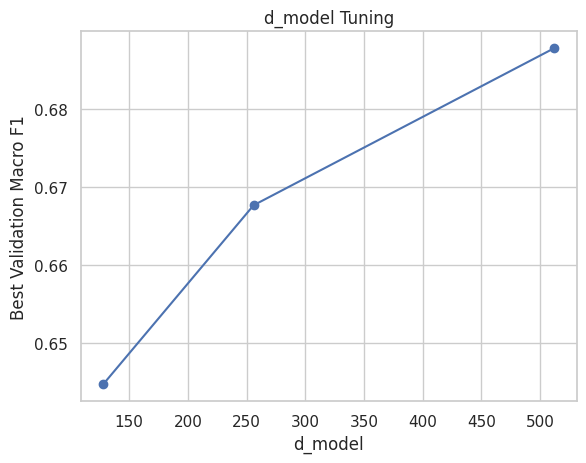

In [25]:
# (Optional) hyperparameter tuning cell
if not hyperparameter_tuning:
    print("Hyperparameter tuning is disabled (set hyperparameter_tuning=True to run this).")
else:
    d_models = [128, 256, 512]
    results = {}

    for d in d_models:
        print(f"\nTraining with d_model = {d}")

        model = FinancialTransformer(
            vocab_size=VOCAB_SIZE,
            d_model=d,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            ff_hidden_dim=FF_HIDDEN_DIM,
            max_len=MAX_LEN,
            num_classes=NUM_CLASSES
        )

        history = train_model(model, train_loader, val_loader, epochs)

        best_f1 = max(history['val_macro_f1'])
        results[d] = best_f1

    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel("d_model")
    plt.ylabel("Best Validation Macro F1")
    plt.title("d_model Tuning")
    plt.show()

    D_MODEL = max(results, key=results.get)



Training with num_heads = 4


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0772 Acc: 0.3909 | Val Loss: 1.0199 Acc: 0.5309 | Val Macro-F1: 0.4247


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9408 Acc: 0.5338 | Val Loss: 0.9273 Acc: 0.5907 | Val Macro-F1: 0.4867


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.7314 Acc: 0.6860 | Val Loss: 0.9727 Acc: 0.5866 | Val Macro-F1: 0.5680


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.5695 Acc: 0.7972 | Val Loss: 0.9318 Acc: 0.6680 | Val Macro-F1: 0.6127


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.4684 Acc: 0.8571 | Val Loss: 1.0086 Acc: 0.6309 | Val Macro-F1: 0.6021


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.4350 Acc: 0.8728 | Val Loss: 0.9279 Acc: 0.6670 | Val Macro-F1: 0.6357


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.3916 Acc: 0.9048 | Val Loss: 0.9493 Acc: 0.7010 | Val Macro-F1: 0.6542


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3514 Acc: 0.9198 | Val Loss: 0.9686 Acc: 0.7031 | Val Macro-F1: 0.6594


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.3412 Acc: 0.9327 | Val Loss: 0.9933 Acc: 0.6845 | Val Macro-F1: 0.6554


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.3238 Acc: 0.9399 | Val Loss: 0.9869 Acc: 0.7052 | Val Macro-F1: 0.6541


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.3005 Acc: 0.9554 | Val Loss: 0.9821 Acc: 0.7031 | Val Macro-F1: 0.6618


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2759 Acc: 0.9678 | Val Loss: 1.0513 Acc: 0.6876 | Val Macro-F1: 0.6591


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.2837 Acc: 0.9634 | Val Loss: 0.9799 Acc: 0.7113 | Val Macro-F1: 0.6643


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.2688 Acc: 0.9678 | Val Loss: 1.0114 Acc: 0.6959 | Val Macro-F1: 0.6629


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.2558 Acc: 0.9763 | Val Loss: 1.0185 Acc: 0.7103 | Val Macro-F1: 0.6641


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.2442 Acc: 0.9825 | Val Loss: 1.0065 Acc: 0.7072 | Val Macro-F1: 0.6613


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.2450 Acc: 0.9812 | Val Loss: 1.0236 Acc: 0.7082 | Val Macro-F1: 0.6660


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.2352 Acc: 0.9861 | Val Loss: 1.0325 Acc: 0.7052 | Val Macro-F1: 0.6663


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.2287 Acc: 0.9881 | Val Loss: 1.0257 Acc: 0.7072 | Val Macro-F1: 0.6652


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.2219 Acc: 0.9912 | Val Loss: 1.0231 Acc: 0.7124 | Val Macro-F1: 0.6686

Training with num_heads = 8


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0712 Acc: 0.4033 | Val Loss: 0.9490 Acc: 0.6196 | Val Macro-F1: 0.4876


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9371 Acc: 0.5413 | Val Loss: 0.9013 Acc: 0.5990 | Val Macro-F1: 0.5376


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6938 Acc: 0.7198 | Val Loss: 0.8599 Acc: 0.6567 | Val Macro-F1: 0.6107


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.5483 Acc: 0.8068 | Val Loss: 0.8640 Acc: 0.6742 | Val Macro-F1: 0.6427


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.4979 Acc: 0.8400 | Val Loss: 0.8985 Acc: 0.6773 | Val Macro-F1: 0.6318


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.4336 Acc: 0.8759 | Val Loss: 0.9178 Acc: 0.6866 | Val Macro-F1: 0.6476


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.3921 Acc: 0.9007 | Val Loss: 0.9411 Acc: 0.6856 | Val Macro-F1: 0.6429


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3393 Acc: 0.9306 | Val Loss: 0.9452 Acc: 0.6845 | Val Macro-F1: 0.6343


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.3303 Acc: 0.9345 | Val Loss: 0.9427 Acc: 0.6969 | Val Macro-F1: 0.6441


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2974 Acc: 0.9549 | Val Loss: 0.9690 Acc: 0.7072 | Val Macro-F1: 0.6515


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2829 Acc: 0.9592 | Val Loss: 1.0111 Acc: 0.6969 | Val Macro-F1: 0.6503


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2655 Acc: 0.9719 | Val Loss: 0.9986 Acc: 0.7010 | Val Macro-F1: 0.6567


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.2561 Acc: 0.9734 | Val Loss: 0.9748 Acc: 0.7062 | Val Macro-F1: 0.6460


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.2421 Acc: 0.9825 | Val Loss: 1.0159 Acc: 0.6969 | Val Macro-F1: 0.6478


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.2328 Acc: 0.9845 | Val Loss: 0.9859 Acc: 0.7155 | Val Macro-F1: 0.6514


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.2266 Acc: 0.9868 | Val Loss: 0.9737 Acc: 0.7196 | Val Macro-F1: 0.6671


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.2224 Acc: 0.9897 | Val Loss: 0.9743 Acc: 0.7268 | Val Macro-F1: 0.6743


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.2208 Acc: 0.9886 | Val Loss: 0.9824 Acc: 0.7031 | Val Macro-F1: 0.6574


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.2110 Acc: 0.9941 | Val Loss: 0.9420 Acc: 0.7247 | Val Macro-F1: 0.6785


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.2091 Acc: 0.9943 | Val Loss: 0.9418 Acc: 0.7268 | Val Macro-F1: 0.6714


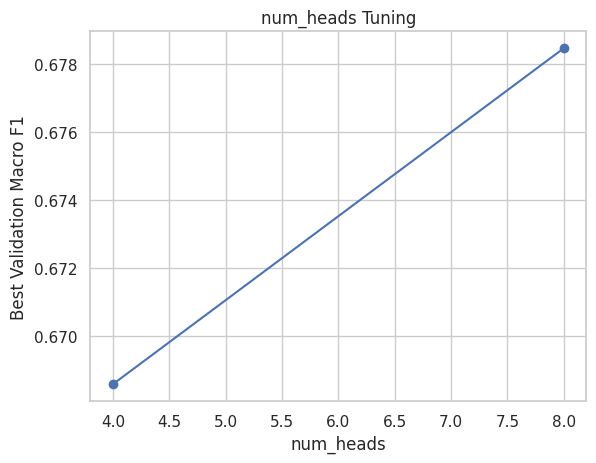

In [26]:
# (Optional) hyperparameter tuning cell
if not hyperparameter_tuning:
    print("Hyperparameter tuning is disabled (set hyperparameter_tuning=True to run this).")
else:
    num_heads = [4, 8]
    results = {}

    for n in num_heads:
        print(f"\nTraining with num_heads = {n}")

        model = FinancialTransformer(
            vocab_size=VOCAB_SIZE,
            d_model=D_MODEL,
            num_heads=n,
            num_layers=NUM_LAYERS,
            ff_hidden_dim=FF_HIDDEN_DIM,
            max_len=MAX_LEN,
            num_classes=NUM_CLASSES
        )

        history = train_model(model, train_loader, val_loader, epochs)

        best_f1 = max(history['val_macro_f1'])
        results[n] = best_f1

    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel("num_heads")
    plt.ylabel("Best Validation Macro F1")
    plt.title("num_heads Tuning")
    plt.show()

    NUM_HEADS = max(results, key=results.get)



Training with num_layers = 2


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0783 Acc: 0.4020 | Val Loss: 1.0450 Acc: 0.5237 | Val Macro-F1: 0.4290


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9552 Acc: 0.5379 | Val Loss: 1.0184 Acc: 0.5237 | Val Macro-F1: 0.4814


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.7678 Acc: 0.6752 | Val Loss: 0.8125 Acc: 0.6784 | Val Macro-F1: 0.6344


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.6083 Acc: 0.7737 | Val Loss: 0.8514 Acc: 0.6753 | Val Macro-F1: 0.6208


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.5216 Acc: 0.8277 | Val Loss: 0.8858 Acc: 0.6866 | Val Macro-F1: 0.6445


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.4683 Acc: 0.8540 | Val Loss: 0.9356 Acc: 0.6680 | Val Macro-F1: 0.6276


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.4152 Acc: 0.8904 | Val Loss: 0.9424 Acc: 0.6887 | Val Macro-F1: 0.6492


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3945 Acc: 0.9002 | Val Loss: 0.9129 Acc: 0.6948 | Val Macro-F1: 0.6480


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.3608 Acc: 0.9180 | Val Loss: 0.9386 Acc: 0.7010 | Val Macro-F1: 0.6509


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.3446 Acc: 0.9270 | Val Loss: 0.9581 Acc: 0.7000 | Val Macro-F1: 0.6543


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.3151 Acc: 0.9461 | Val Loss: 0.9869 Acc: 0.7000 | Val Macro-F1: 0.6520


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.3075 Acc: 0.9481 | Val Loss: 1.0026 Acc: 0.6887 | Val Macro-F1: 0.6498


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.2885 Acc: 0.9592 | Val Loss: 0.9834 Acc: 0.7237 | Val Macro-F1: 0.6766


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.2861 Acc: 0.9631 | Val Loss: 0.9806 Acc: 0.7093 | Val Macro-F1: 0.6693


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.2659 Acc: 0.9737 | Val Loss: 1.0072 Acc: 0.7010 | Val Macro-F1: 0.6582


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.2640 Acc: 0.9711 | Val Loss: 1.0233 Acc: 0.6959 | Val Macro-F1: 0.6569


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.2552 Acc: 0.9770 | Val Loss: 0.9891 Acc: 0.7206 | Val Macro-F1: 0.6764


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.2467 Acc: 0.9825 | Val Loss: 1.0058 Acc: 0.7196 | Val Macro-F1: 0.6766
Early stopping: no improvement in Macro-F1 for 5 epochs.

Training with num_layers = 3


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0806 Acc: 0.3989 | Val Loss: 1.0063 Acc: 0.5423 | Val Macro-F1: 0.3892


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9218 Acc: 0.5596 | Val Loss: 0.9069 Acc: 0.5918 | Val Macro-F1: 0.5381


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6867 Acc: 0.7196 | Val Loss: 0.8021 Acc: 0.6990 | Val Macro-F1: 0.6458


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.5619 Acc: 0.7970 | Val Loss: 0.8023 Acc: 0.7052 | Val Macro-F1: 0.6421


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.4876 Acc: 0.8467 | Val Loss: 0.8370 Acc: 0.6876 | Val Macro-F1: 0.6406


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.4179 Acc: 0.8849 | Val Loss: 0.9341 Acc: 0.6804 | Val Macro-F1: 0.6407


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.3768 Acc: 0.9097 | Val Loss: 0.9155 Acc: 0.6948 | Val Macro-F1: 0.6581


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3487 Acc: 0.9265 | Val Loss: 0.9464 Acc: 0.6825 | Val Macro-F1: 0.6503


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.3279 Acc: 0.9334 | Val Loss: 1.0124 Acc: 0.6639 | Val Macro-F1: 0.6395


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.3041 Acc: 0.9515 | Val Loss: 0.9709 Acc: 0.6845 | Val Macro-F1: 0.6473


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2905 Acc: 0.9556 | Val Loss: 0.9516 Acc: 0.7082 | Val Macro-F1: 0.6621


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2690 Acc: 0.9685 | Val Loss: 0.9789 Acc: 0.7041 | Val Macro-F1: 0.6665


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.2651 Acc: 0.9727 | Val Loss: 0.9741 Acc: 0.7247 | Val Macro-F1: 0.6715


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.2521 Acc: 0.9757 | Val Loss: 1.0133 Acc: 0.7113 | Val Macro-F1: 0.6602


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.2450 Acc: 0.9788 | Val Loss: 0.9979 Acc: 0.7186 | Val Macro-F1: 0.6613


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.2389 Acc: 0.9848 | Val Loss: 0.9964 Acc: 0.7309 | Val Macro-F1: 0.6767


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.2277 Acc: 0.9881 | Val Loss: 0.9668 Acc: 0.7268 | Val Macro-F1: 0.6819


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.2345 Acc: 0.9835 | Val Loss: 1.0013 Acc: 0.7247 | Val Macro-F1: 0.6806


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.2167 Acc: 0.9930 | Val Loss: 1.0085 Acc: 0.7093 | Val Macro-F1: 0.6729


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.2135 Acc: 0.9933 | Val Loss: 0.9842 Acc: 0.7299 | Val Macro-F1: 0.6796

Training with num_layers = 4


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0733 Acc: 0.4043 | Val Loss: 1.0078 Acc: 0.5598 | Val Macro-F1: 0.4046


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9255 Acc: 0.5524 | Val Loss: 0.8690 Acc: 0.6340 | Val Macro-F1: 0.5759


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6614 Acc: 0.7356 | Val Loss: 0.8796 Acc: 0.6660 | Val Macro-F1: 0.6157


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.5427 Acc: 0.8083 | Val Loss: 0.8271 Acc: 0.6845 | Val Macro-F1: 0.6386


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.4474 Acc: 0.8664 | Val Loss: 0.8901 Acc: 0.6845 | Val Macro-F1: 0.6478


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.4105 Acc: 0.8909 | Val Loss: 0.9096 Acc: 0.6897 | Val Macro-F1: 0.6548


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.3616 Acc: 0.9164 | Val Loss: 0.8963 Acc: 0.7062 | Val Macro-F1: 0.6665


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3298 Acc: 0.9360 | Val Loss: 0.9290 Acc: 0.7268 | Val Macro-F1: 0.6708


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.3067 Acc: 0.9507 | Val Loss: 0.9659 Acc: 0.7062 | Val Macro-F1: 0.6627


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2772 Acc: 0.9672 | Val Loss: 0.9577 Acc: 0.7186 | Val Macro-F1: 0.6719


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2573 Acc: 0.9724 | Val Loss: 1.0214 Acc: 0.7031 | Val Macro-F1: 0.6650


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2492 Acc: 0.9801 | Val Loss: 0.9579 Acc: 0.7299 | Val Macro-F1: 0.6806


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.2409 Acc: 0.9825 | Val Loss: 0.9336 Acc: 0.7361 | Val Macro-F1: 0.6882


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.2262 Acc: 0.9874 | Val Loss: 0.9593 Acc: 0.7392 | Val Macro-F1: 0.6962


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.2212 Acc: 0.9879 | Val Loss: 0.9466 Acc: 0.7361 | Val Macro-F1: 0.6920


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.2155 Acc: 0.9910 | Val Loss: 0.9677 Acc: 0.7227 | Val Macro-F1: 0.6879


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.2069 Acc: 0.9933 | Val Loss: 0.9699 Acc: 0.7340 | Val Macro-F1: 0.6838


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.2053 Acc: 0.9946 | Val Loss: 0.9615 Acc: 0.7268 | Val Macro-F1: 0.6825


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.1994 Acc: 0.9956 | Val Loss: 0.9575 Acc: 0.7144 | Val Macro-F1: 0.6811
Early stopping: no improvement in Macro-F1 for 5 epochs.


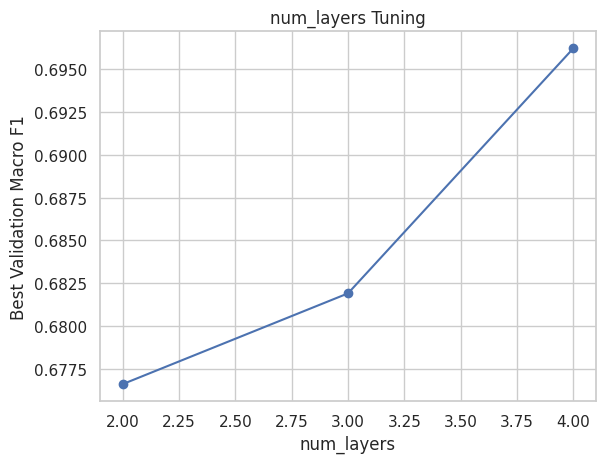

In [27]:
# (Optional) hyperparameter tuning cell
if not hyperparameter_tuning:
    print("Hyperparameter tuning is disabled (set hyperparameter_tuning=True to run this).")
else:
    num_layers = [2, 3, 4]
    results = {}

    for n in num_layers:
        print(f"\nTraining with num_layers = {n}")

        model = FinancialTransformer(
            vocab_size=VOCAB_SIZE,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            num_layers=n,
            ff_hidden_dim=FF_HIDDEN_DIM,
            max_len=MAX_LEN,
            num_classes=NUM_CLASSES
        )

        history = train_model(model, train_loader, val_loader, epochs)

        best_f1 = max(history['val_macro_f1'])
        results[n] = best_f1

    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel("num_layers")
    plt.ylabel("Best Validation Macro F1")
    plt.title("num_layers Tuning")
    plt.show()

    NUM_LAYERS = max(results, key=results.get)



Training with ff_hidden_dim = 1024


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0681 Acc: 0.4125 | Val Loss: 1.0019 Acc: 0.5722 | Val Macro-F1: 0.4233


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9183 Acc: 0.5472 | Val Loss: 0.8350 Acc: 0.6701 | Val Macro-F1: 0.6017


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6846 Acc: 0.7281 | Val Loss: 0.8471 Acc: 0.6691 | Val Macro-F1: 0.6310


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.5578 Acc: 0.7959 | Val Loss: 0.8471 Acc: 0.6866 | Val Macro-F1: 0.6442


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.4733 Acc: 0.8522 | Val Loss: 0.8472 Acc: 0.7144 | Val Macro-F1: 0.6723


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.4047 Acc: 0.8883 | Val Loss: 0.8754 Acc: 0.7320 | Val Macro-F1: 0.6807


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.3621 Acc: 0.9198 | Val Loss: 0.9211 Acc: 0.7268 | Val Macro-F1: 0.6763


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3374 Acc: 0.9332 | Val Loss: 0.8932 Acc: 0.7227 | Val Macro-F1: 0.6737


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.3221 Acc: 0.9407 | Val Loss: 0.8687 Acc: 0.7351 | Val Macro-F1: 0.6902


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2921 Acc: 0.9559 | Val Loss: 0.9067 Acc: 0.7340 | Val Macro-F1: 0.6967


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2753 Acc: 0.9659 | Val Loss: 0.9025 Acc: 0.7629 | Val Macro-F1: 0.7158


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2668 Acc: 0.9693 | Val Loss: 0.9227 Acc: 0.7505 | Val Macro-F1: 0.7070


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.2458 Acc: 0.9791 | Val Loss: 0.9072 Acc: 0.7557 | Val Macro-F1: 0.7146


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.2366 Acc: 0.9809 | Val Loss: 0.9282 Acc: 0.7546 | Val Macro-F1: 0.7169


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.2327 Acc: 0.9840 | Val Loss: 0.9286 Acc: 0.7660 | Val Macro-F1: 0.7198


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.2247 Acc: 0.9894 | Val Loss: 0.9377 Acc: 0.7577 | Val Macro-F1: 0.7075


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.2140 Acc: 0.9928 | Val Loss: 0.9527 Acc: 0.7546 | Val Macro-F1: 0.7108


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.2111 Acc: 0.9912 | Val Loss: 0.9310 Acc: 0.7588 | Val Macro-F1: 0.7073


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.2076 Acc: 0.9938 | Val Loss: 0.9179 Acc: 0.7474 | Val Macro-F1: 0.7067


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.2007 Acc: 0.9948 | Val Loss: 0.9012 Acc: 0.7454 | Val Macro-F1: 0.6976
Early stopping: no improvement in Macro-F1 for 5 epochs.

Training with ff_hidden_dim = 2048


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0683 Acc: 0.4110 | Val Loss: 0.9263 Acc: 0.6227 | Val Macro-F1: 0.5074


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9178 Acc: 0.5550 | Val Loss: 0.9439 Acc: 0.5948 | Val Macro-F1: 0.5717


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6647 Acc: 0.7345 | Val Loss: 0.9520 Acc: 0.5959 | Val Macro-F1: 0.5813


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.5318 Acc: 0.8166 | Val Loss: 0.9501 Acc: 0.6351 | Val Macro-F1: 0.6055


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.4563 Acc: 0.8584 | Val Loss: 0.8671 Acc: 0.7072 | Val Macro-F1: 0.6613


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.3917 Acc: 0.9002 | Val Loss: 0.8881 Acc: 0.7000 | Val Macro-F1: 0.6619


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.3550 Acc: 0.9291 | Val Loss: 0.9338 Acc: 0.7062 | Val Macro-F1: 0.6625


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3209 Acc: 0.9404 | Val Loss: 0.9332 Acc: 0.7144 | Val Macro-F1: 0.6717


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.2981 Acc: 0.9518 | Val Loss: 1.0267 Acc: 0.6835 | Val Macro-F1: 0.6513


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2790 Acc: 0.9631 | Val Loss: 1.0282 Acc: 0.6866 | Val Macro-F1: 0.6532


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2619 Acc: 0.9685 | Val Loss: 0.9596 Acc: 0.7340 | Val Macro-F1: 0.6876


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2510 Acc: 0.9757 | Val Loss: 0.9768 Acc: 0.7124 | Val Macro-F1: 0.6594


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.2332 Acc: 0.9843 | Val Loss: 0.9593 Acc: 0.7186 | Val Macro-F1: 0.6696


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.2273 Acc: 0.9856 | Val Loss: 0.9566 Acc: 0.7278 | Val Macro-F1: 0.6795


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.2204 Acc: 0.9871 | Val Loss: 0.9688 Acc: 0.7206 | Val Macro-F1: 0.6696


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.2100 Acc: 0.9912 | Val Loss: 1.0327 Acc: 0.7052 | Val Macro-F1: 0.6677
Early stopping: no improvement in Macro-F1 for 5 epochs.


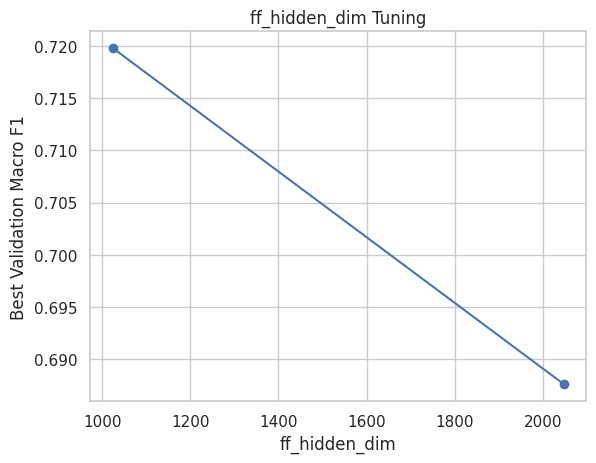

In [28]:
# (Optional) hyperparameter tuning cell
if not hyperparameter_tuning:
    print("Hyperparameter tuning is disabled (set hyperparameter_tuning=True to run this).")
else:
    ff_hidden_dim = [2 * D_MODEL, 4 * D_MODEL]
    results = {}

    for n in ff_hidden_dim:
        print(f"\nTraining with ff_hidden_dim = {n}")

        model = FinancialTransformer(
            vocab_size=VOCAB_SIZE,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            ff_hidden_dim=n,
            max_len=MAX_LEN,
            num_classes=NUM_CLASSES
        )

        history = train_model(model, train_loader, val_loader, epochs)

        best_f1 = max(history['val_macro_f1'])
        results[n] = best_f1

    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel("ff_hidden_dim")
    plt.ylabel("Best Validation Macro F1")
    plt.title("ff_hidden_dim Tuning")
    plt.show()

    FF_HIDDEN_DIM = max(results, key=results.get)



Training with dropout_val = 0.15


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0774 Acc: 0.3816 | Val Loss: 0.9549 Acc: 0.5959 | Val Macro-F1: 0.4455


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9159 Acc: 0.5650 | Val Loss: 0.8318 Acc: 0.6361 | Val Macro-F1: 0.5905


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6801 Acc: 0.7214 | Val Loss: 0.8979 Acc: 0.6278 | Val Macro-F1: 0.6039


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.5408 Acc: 0.8171 | Val Loss: 0.8509 Acc: 0.6918 | Val Macro-F1: 0.6388


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.4639 Acc: 0.8566 | Val Loss: 0.8299 Acc: 0.7093 | Val Macro-F1: 0.6730


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.3975 Acc: 0.8963 | Val Loss: 0.9005 Acc: 0.7258 | Val Macro-F1: 0.6773


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.3739 Acc: 0.9100 | Val Loss: 0.9409 Acc: 0.6856 | Val Macro-F1: 0.6504


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3339 Acc: 0.9303 | Val Loss: 0.9535 Acc: 0.7165 | Val Macro-F1: 0.6735


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.2987 Acc: 0.9528 | Val Loss: 0.9478 Acc: 0.7165 | Val Macro-F1: 0.6770


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2842 Acc: 0.9621 | Val Loss: 0.9929 Acc: 0.7021 | Val Macro-F1: 0.6629


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2727 Acc: 0.9647 | Val Loss: 0.9753 Acc: 0.7155 | Val Macro-F1: 0.6775


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2530 Acc: 0.9739 | Val Loss: 0.9703 Acc: 0.7206 | Val Macro-F1: 0.6679


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.2406 Acc: 0.9807 | Val Loss: 0.9956 Acc: 0.7216 | Val Macro-F1: 0.6767


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.2317 Acc: 0.9858 | Val Loss: 1.0111 Acc: 0.7227 | Val Macro-F1: 0.6747


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.2281 Acc: 0.9840 | Val Loss: 0.9805 Acc: 0.7351 | Val Macro-F1: 0.6791


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.2191 Acc: 0.9886 | Val Loss: 0.9923 Acc: 0.7258 | Val Macro-F1: 0.6764


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.2129 Acc: 0.9928 | Val Loss: 0.9822 Acc: 0.7247 | Val Macro-F1: 0.6806


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.2061 Acc: 0.9936 | Val Loss: 0.9436 Acc: 0.7309 | Val Macro-F1: 0.6804


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.2043 Acc: 0.9946 | Val Loss: 0.9499 Acc: 0.7454 | Val Macro-F1: 0.6929


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.1974 Acc: 0.9948 | Val Loss: 0.9456 Acc: 0.7371 | Val Macro-F1: 0.6831

Training with dropout_val = 0.25


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0781 Acc: 0.3831 | Val Loss: 1.0073 Acc: 0.5330 | Val Macro-F1: 0.4565


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9164 Acc: 0.5482 | Val Loss: 0.8470 Acc: 0.6289 | Val Macro-F1: 0.5706


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6681 Acc: 0.7288 | Val Loss: 0.8459 Acc: 0.6701 | Val Macro-F1: 0.6154


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.5554 Acc: 0.8037 | Val Loss: 0.8909 Acc: 0.6732 | Val Macro-F1: 0.6300


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.4739 Acc: 0.8480 | Val Loss: 0.9162 Acc: 0.6959 | Val Macro-F1: 0.6395


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.4014 Acc: 0.8919 | Val Loss: 0.9035 Acc: 0.7155 | Val Macro-F1: 0.6577


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.3555 Acc: 0.9169 | Val Loss: 0.9906 Acc: 0.6876 | Val Macro-F1: 0.6564


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3421 Acc: 0.9314 | Val Loss: 0.9847 Acc: 0.6938 | Val Macro-F1: 0.6598


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.3081 Acc: 0.9466 | Val Loss: 1.0041 Acc: 0.6959 | Val Macro-F1: 0.6640


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2888 Acc: 0.9582 | Val Loss: 0.9327 Acc: 0.7093 | Val Macro-F1: 0.6662


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2712 Acc: 0.9667 | Val Loss: 1.0003 Acc: 0.7021 | Val Macro-F1: 0.6604


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2554 Acc: 0.9747 | Val Loss: 0.9923 Acc: 0.7206 | Val Macro-F1: 0.6742


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.2497 Acc: 0.9783 | Val Loss: 0.9989 Acc: 0.7155 | Val Macro-F1: 0.6751


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.2312 Acc: 0.9858 | Val Loss: 1.0003 Acc: 0.7113 | Val Macro-F1: 0.6621


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.2275 Acc: 0.9871 | Val Loss: 1.0160 Acc: 0.7093 | Val Macro-F1: 0.6728


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.2199 Acc: 0.9902 | Val Loss: 0.9816 Acc: 0.7247 | Val Macro-F1: 0.6796


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.2132 Acc: 0.9933 | Val Loss: 0.9796 Acc: 0.7216 | Val Macro-F1: 0.6749


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.2103 Acc: 0.9930 | Val Loss: 0.9841 Acc: 0.7247 | Val Macro-F1: 0.6805


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.2070 Acc: 0.9943 | Val Loss: 1.0119 Acc: 0.7082 | Val Macro-F1: 0.6695


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.1972 Acc: 0.9969 | Val Loss: 0.9872 Acc: 0.7165 | Val Macro-F1: 0.6727

Training with dropout_val = 0.35


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0799 Acc: 0.3785 | Val Loss: 0.9957 Acc: 0.5701 | Val Macro-F1: 0.4810


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9152 Acc: 0.5580 | Val Loss: 0.8536 Acc: 0.6412 | Val Macro-F1: 0.5857


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6876 Acc: 0.7281 | Val Loss: 0.8201 Acc: 0.6660 | Val Macro-F1: 0.5867


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.5455 Acc: 0.7990 | Val Loss: 0.9190 Acc: 0.6639 | Val Macro-F1: 0.6176


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.4685 Acc: 0.8498 | Val Loss: 0.9106 Acc: 0.7041 | Val Macro-F1: 0.6416


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.3945 Acc: 0.8911 | Val Loss: 0.9096 Acc: 0.7268 | Val Macro-F1: 0.6592


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.3659 Acc: 0.9143 | Val Loss: 0.9002 Acc: 0.7186 | Val Macro-F1: 0.6616


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3236 Acc: 0.9329 | Val Loss: 0.9340 Acc: 0.7258 | Val Macro-F1: 0.6669


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.3003 Acc: 0.9525 | Val Loss: 1.0030 Acc: 0.7155 | Val Macro-F1: 0.6605


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2880 Acc: 0.9561 | Val Loss: 1.0118 Acc: 0.7052 | Val Macro-F1: 0.6663


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2686 Acc: 0.9690 | Val Loss: 0.9950 Acc: 0.7155 | Val Macro-F1: 0.6686


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2521 Acc: 0.9768 | Val Loss: 0.9772 Acc: 0.7351 | Val Macro-F1: 0.6706


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.2408 Acc: 0.9817 | Val Loss: 0.9860 Acc: 0.7289 | Val Macro-F1: 0.6747


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.2304 Acc: 0.9845 | Val Loss: 0.9967 Acc: 0.7144 | Val Macro-F1: 0.6592


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.2197 Acc: 0.9917 | Val Loss: 0.9739 Acc: 0.7186 | Val Macro-F1: 0.6654


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.2152 Acc: 0.9915 | Val Loss: 0.9753 Acc: 0.7361 | Val Macro-F1: 0.6750


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.2137 Acc: 0.9905 | Val Loss: 0.9858 Acc: 0.7330 | Val Macro-F1: 0.6760


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.2061 Acc: 0.9938 | Val Loss: 0.9582 Acc: 0.7227 | Val Macro-F1: 0.6676


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.2041 Acc: 0.9933 | Val Loss: 0.9865 Acc: 0.7186 | Val Macro-F1: 0.6751


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.2000 Acc: 0.9956 | Val Loss: 1.0055 Acc: 0.6969 | Val Macro-F1: 0.6579

Training with dropout_val = 0.45


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0756 Acc: 0.3942 | Val Loss: 0.9626 Acc: 0.5773 | Val Macro-F1: 0.3970


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9018 Acc: 0.5601 | Val Loss: 0.8996 Acc: 0.5887 | Val Macro-F1: 0.5779


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6709 Acc: 0.7234 | Val Loss: 0.8324 Acc: 0.6639 | Val Macro-F1: 0.6355


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.5638 Acc: 0.8001 | Val Loss: 0.8824 Acc: 0.6526 | Val Macro-F1: 0.6397


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.4739 Acc: 0.8545 | Val Loss: 0.8348 Acc: 0.7031 | Val Macro-F1: 0.6724


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.3931 Acc: 0.8983 | Val Loss: 0.8748 Acc: 0.7381 | Val Macro-F1: 0.6920


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.3708 Acc: 0.9138 | Val Loss: 0.9253 Acc: 0.7021 | Val Macro-F1: 0.6713


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.3316 Acc: 0.9381 | Val Loss: 0.9218 Acc: 0.7237 | Val Macro-F1: 0.6843


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.3046 Acc: 0.9520 | Val Loss: 0.9333 Acc: 0.7124 | Val Macro-F1: 0.6732


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2885 Acc: 0.9600 | Val Loss: 0.9190 Acc: 0.7258 | Val Macro-F1: 0.6861


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2605 Acc: 0.9701 | Val Loss: 0.9463 Acc: 0.7340 | Val Macro-F1: 0.6925


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2582 Acc: 0.9729 | Val Loss: 0.9430 Acc: 0.7330 | Val Macro-F1: 0.6988


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.2496 Acc: 0.9752 | Val Loss: 0.9212 Acc: 0.7474 | Val Macro-F1: 0.7047


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.2356 Acc: 0.9840 | Val Loss: 0.9708 Acc: 0.7278 | Val Macro-F1: 0.6878


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.2263 Acc: 0.9874 | Val Loss: 0.9450 Acc: 0.7330 | Val Macro-F1: 0.6946


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.2212 Acc: 0.9871 | Val Loss: 0.9561 Acc: 0.7268 | Val Macro-F1: 0.6860


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.2121 Acc: 0.9941 | Val Loss: 0.9532 Acc: 0.7289 | Val Macro-F1: 0.6915


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.2104 Acc: 0.9930 | Val Loss: 0.9301 Acc: 0.7381 | Val Macro-F1: 0.6965
Early stopping: no improvement in Macro-F1 for 5 epochs.


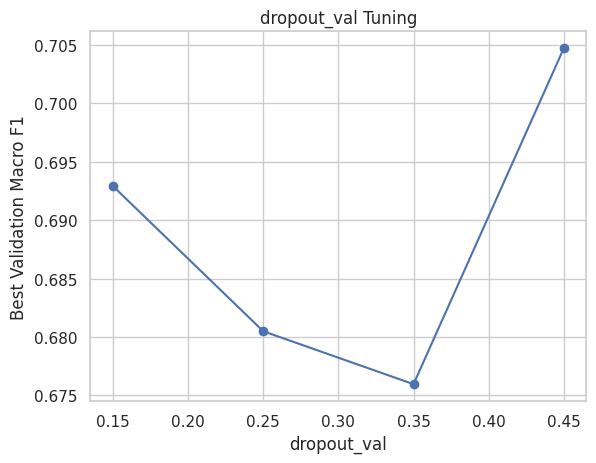

In [29]:
# (Optional) hyperparameter tuning cell
if not hyperparameter_tuning:
    print("Hyperparameter tuning is disabled (set hyperparameter_tuning=True to run this).")
else:
    results = {}

    for d in [0.15, 0.25, 0.35, 0.45]:
        print(f"\nTraining with dropout_val = {d}")


        dropout_val = d

        model = FinancialTransformer(
            vocab_size=VOCAB_SIZE,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            ff_hidden_dim=FF_HIDDEN_DIM,
            max_len=MAX_LEN,
            num_classes=NUM_CLASSES
        )

        history = train_model(model, train_loader, val_loader, epochs)
        best_f1 = max(history['val_macro_f1'])
        results[d] = best_f1


    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel("dropout_val")
    plt.ylabel("Best Validation Macro F1")
    plt.title("dropout_val Tuning")
    plt.show()

    dropout_val = max(results, key=results.get)



Training with learning rate = 5e-05


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.1048 Acc: 0.3171 | Val Loss: 1.0787 Acc: 0.4577 | Val Macro-F1: 0.3854


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 1.0754 Acc: 0.3947 | Val Loss: 1.0239 Acc: 0.5567 | Val Macro-F1: 0.4332


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 1.0157 Acc: 0.4683 | Val Loss: 0.9575 Acc: 0.5887 | Val Macro-F1: 0.4523


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.9758 Acc: 0.5101 | Val Loss: 0.9607 Acc: 0.5670 | Val Macro-F1: 0.4772


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.9404 Acc: 0.5369 | Val Loss: 0.9174 Acc: 0.5825 | Val Macro-F1: 0.4909


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.9130 Acc: 0.5580 | Val Loss: 0.9363 Acc: 0.5804 | Val Macro-F1: 0.5116


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.8871 Acc: 0.5810 | Val Loss: 0.9238 Acc: 0.5866 | Val Macro-F1: 0.5265


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.8557 Acc: 0.6063 | Val Loss: 0.8524 Acc: 0.6247 | Val Macro-F1: 0.5518


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.8008 Acc: 0.6455 | Val Loss: 0.8450 Acc: 0.6268 | Val Macro-F1: 0.5551


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.7927 Acc: 0.6507 | Val Loss: 0.8655 Acc: 0.6237 | Val Macro-F1: 0.5630


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.7400 Acc: 0.6845 | Val Loss: 0.8696 Acc: 0.6289 | Val Macro-F1: 0.5708


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.7128 Acc: 0.7059 | Val Loss: 0.8563 Acc: 0.6340 | Val Macro-F1: 0.5841


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.7016 Acc: 0.7126 | Val Loss: 0.8229 Acc: 0.6474 | Val Macro-F1: 0.6027


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.6947 Acc: 0.7118 | Val Loss: 0.8282 Acc: 0.6495 | Val Macro-F1: 0.6037


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.6819 Acc: 0.7167 | Val Loss: 0.8586 Acc: 0.6433 | Val Macro-F1: 0.5993


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.6505 Acc: 0.7405 | Val Loss: 0.8255 Acc: 0.6526 | Val Macro-F1: 0.6054


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.6369 Acc: 0.7374 | Val Loss: 0.8412 Acc: 0.6433 | Val Macro-F1: 0.5950


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.6130 Acc: 0.7593 | Val Loss: 0.8397 Acc: 0.6485 | Val Macro-F1: 0.6025


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.6266 Acc: 0.7552 | Val Loss: 0.8170 Acc: 0.6577 | Val Macro-F1: 0.6103


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.6026 Acc: 0.7639 | Val Loss: 0.8553 Acc: 0.6392 | Val Macro-F1: 0.5952

Training with learning rate = 0.0001


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.1029 Acc: 0.3514 | Val Loss: 1.0561 Acc: 0.5155 | Val Macro-F1: 0.3902


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 1.0282 Acc: 0.4672 | Val Loss: 0.9336 Acc: 0.6010 | Val Macro-F1: 0.5047


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.9482 Acc: 0.5359 | Val Loss: 0.9009 Acc: 0.6052 | Val Macro-F1: 0.5188


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.8520 Acc: 0.6107 | Val Loss: 0.8562 Acc: 0.6278 | Val Macro-F1: 0.5791


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.7540 Acc: 0.6669 | Val Loss: 0.8580 Acc: 0.6320 | Val Macro-F1: 0.5950


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.7138 Acc: 0.7015 | Val Loss: 0.9016 Acc: 0.6103 | Val Macro-F1: 0.5728


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.6483 Acc: 0.7312 | Val Loss: 0.8520 Acc: 0.6361 | Val Macro-F1: 0.5991


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.6168 Acc: 0.7570 | Val Loss: 0.8483 Acc: 0.6526 | Val Macro-F1: 0.6160


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.5833 Acc: 0.7660 | Val Loss: 0.8428 Acc: 0.6577 | Val Macro-F1: 0.6096


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.5432 Acc: 0.8003 | Val Loss: 0.8715 Acc: 0.6588 | Val Macro-F1: 0.6263


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.5100 Acc: 0.8238 | Val Loss: 0.8788 Acc: 0.6763 | Val Macro-F1: 0.6389


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.4948 Acc: 0.8333 | Val Loss: 0.8937 Acc: 0.6753 | Val Macro-F1: 0.6358


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.4796 Acc: 0.8457 | Val Loss: 0.8802 Acc: 0.6969 | Val Macro-F1: 0.6563


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.4678 Acc: 0.8488 | Val Loss: 0.8606 Acc: 0.7186 | Val Macro-F1: 0.6675


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.4342 Acc: 0.8638 | Val Loss: 0.9080 Acc: 0.6918 | Val Macro-F1: 0.6544


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.4241 Acc: 0.8790 | Val Loss: 0.8856 Acc: 0.7155 | Val Macro-F1: 0.6714


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.4105 Acc: 0.8924 | Val Loss: 0.9114 Acc: 0.7031 | Val Macro-F1: 0.6663


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.4099 Acc: 0.8906 | Val Loss: 0.9422 Acc: 0.6866 | Val Macro-F1: 0.6509


Epoch 19/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.3780 Acc: 0.9097 | Val Loss: 0.9459 Acc: 0.6897 | Val Macro-F1: 0.6520


Epoch 20/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.3880 Acc: 0.8999 | Val Loss: 0.9463 Acc: 0.7000 | Val Macro-F1: 0.6604

Training with learning rate = 0.0002


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0866 Acc: 0.3793 | Val Loss: 1.0584 Acc: 0.4485 | Val Macro-F1: 0.3417


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.9619 Acc: 0.5183 | Val Loss: 0.8524 Acc: 0.6371 | Val Macro-F1: 0.5454


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.8159 Acc: 0.6280 | Val Loss: 0.9035 Acc: 0.6299 | Val Macro-F1: 0.5988


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.6536 Acc: 0.7358 | Val Loss: 0.8997 Acc: 0.6588 | Val Macro-F1: 0.6209


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.5629 Acc: 0.7998 | Val Loss: 0.8914 Acc: 0.6649 | Val Macro-F1: 0.6185


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.5035 Acc: 0.8295 | Val Loss: 0.9600 Acc: 0.6412 | Val Macro-F1: 0.6085


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.4535 Acc: 0.8573 | Val Loss: 0.8637 Acc: 0.6990 | Val Macro-F1: 0.6524


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.4156 Acc: 0.8849 | Val Loss: 0.8932 Acc: 0.7072 | Val Macro-F1: 0.6699


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.3735 Acc: 0.9076 | Val Loss: 0.9309 Acc: 0.7093 | Val Macro-F1: 0.6681


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.3573 Acc: 0.9167 | Val Loss: 0.9015 Acc: 0.7103 | Val Macro-F1: 0.6667


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.3375 Acc: 0.9314 | Val Loss: 0.9281 Acc: 0.6990 | Val Macro-F1: 0.6564


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.3291 Acc: 0.9409 | Val Loss: 0.9398 Acc: 0.7124 | Val Macro-F1: 0.6637


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.3009 Acc: 0.9554 | Val Loss: 0.9550 Acc: 0.7010 | Val Macro-F1: 0.6611
Early stopping: no improvement in Macro-F1 for 5 epochs.

Training with learning rate = 0.0005


Epoch 1/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.0662 Acc: 0.4045 | Val Loss: 0.9407 Acc: 0.5804 | Val Macro-F1: 0.4687


Epoch 2/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 0.8189 Acc: 0.6360 | Val Loss: 0.8469 Acc: 0.6701 | Val Macro-F1: 0.5797


Epoch 3/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 0.6035 Acc: 0.7743 | Val Loss: 0.9492 Acc: 0.6454 | Val Macro-F1: 0.6236


Epoch 4/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 0.4537 Acc: 0.8620 | Val Loss: 0.8839 Acc: 0.6969 | Val Macro-F1: 0.6470


Epoch 5/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 0.3766 Acc: 0.9100 | Val Loss: 0.9653 Acc: 0.6979 | Val Macro-F1: 0.6492


Epoch 6/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 0.3257 Acc: 0.9373 | Val Loss: 0.8952 Acc: 0.7144 | Val Macro-F1: 0.6813


Epoch 7/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 0.2922 Acc: 0.9533 | Val Loss: 1.0387 Acc: 0.6845 | Val Macro-F1: 0.6534


Epoch 8/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 0.2652 Acc: 0.9680 | Val Loss: 0.9972 Acc: 0.7206 | Val Macro-F1: 0.6799


Epoch 9/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 0.2423 Acc: 0.9776 | Val Loss: 0.9847 Acc: 0.7196 | Val Macro-F1: 0.6775


Epoch 10/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 0.2281 Acc: 0.9840 | Val Loss: 1.0489 Acc: 0.7165 | Val Macro-F1: 0.6806


Epoch 11/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 0.2132 Acc: 0.9868 | Val Loss: 0.9580 Acc: 0.7330 | Val Macro-F1: 0.6827


Epoch 12/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.2052 Acc: 0.9902 | Val Loss: 0.9390 Acc: 0.7186 | Val Macro-F1: 0.6808


Epoch 13/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.1972 Acc: 0.9912 | Val Loss: 0.9266 Acc: 0.7433 | Val Macro-F1: 0.6985


Epoch 14/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.1875 Acc: 0.9943 | Val Loss: 0.9465 Acc: 0.7340 | Val Macro-F1: 0.6879


Epoch 15/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.1810 Acc: 0.9969 | Val Loss: 1.0061 Acc: 0.7144 | Val Macro-F1: 0.6821


Epoch 16/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.1817 Acc: 0.9964 | Val Loss: 1.0195 Acc: 0.7206 | Val Macro-F1: 0.6790


Epoch 17/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.1801 Acc: 0.9966 | Val Loss: 1.0329 Acc: 0.7361 | Val Macro-F1: 0.6856


Epoch 18/20:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.1777 Acc: 0.9974 | Val Loss: 1.0042 Acc: 0.7175 | Val Macro-F1: 0.6757
Early stopping: no improvement in Macro-F1 for 5 epochs.


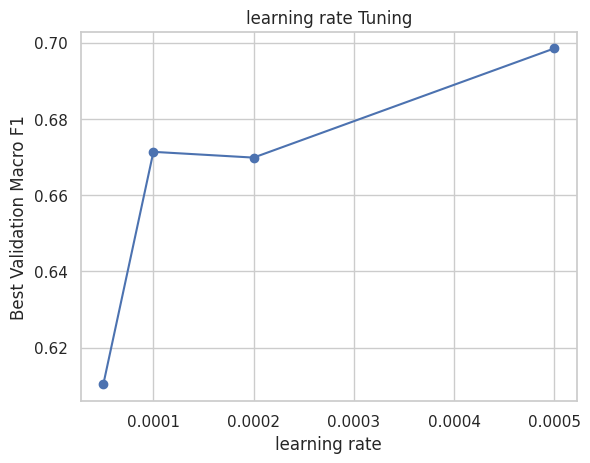

In [30]:
# (Optional) hyperparameter tuning cell
if not hyperparameter_tuning:
    print("Hyperparameter tuning is disabled (set hyperparameter_tuning=True to run this).")
else:
    results = {}


    for lr in [5e-5, 1e-4, 2e-4, 5e-4]:
        print(f"\nTraining with learning rate = {lr}")


        learning_rate = lr

        model = FinancialTransformer(
            vocab_size=VOCAB_SIZE,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            ff_hidden_dim=FF_HIDDEN_DIM,
            max_len=MAX_LEN,
            num_classes=NUM_CLASSES
        )

        history = train_model(model, train_loader, val_loader, epochs)
        best_f1 = max(history['val_macro_f1'])
        results[lr] = best_f1


    plt.figure()
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel("learning rate")
    plt.ylabel("Best Validation Macro F1")
    plt.title("learning rate Tuning")
    plt.show()

    learning_rate = max(results, key=results.get)


In [ ]:
D_MODEL = 512
NUM_HEADS = 8
NUM_LAYERS = 4
FF_HIDEN_DIM = 2 * D_MODEL
dropout_val = 0.35
learning_rate = 5e-4

In [31]:
# Handling Hyperparameter manualy to avoid re-run hyperparameter tuning

print(f'D_MODEL: {D_MODEL} | NUM_HEADS: {NUM_HEADS} | NUM_LAYERS: {NUM_LAYERS} | FF_HIDDEN_DIM: {FF_HIDDEN_DIM} | dropout_val: {dropout_val} | learning_rate: {learning_rate}')


D_MODEL: 512 | NUM_HEADS: 8 | NUM_LAYERS: 4 | FF_HIDDEN_DIM: 1024 | dropout_val: 0.45 | learning_rate: 0.0005


In [32]:
# (Re)build the model using the current config
model = FinancialTransformer(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    ff_hidden_dim=FF_HIDDEN_DIM,
    max_len=MAX_LEN,
    num_classes=NUM_CLASSES,
    dropout=dropout_val,
    pad_token_id=PAD_TOKEN_ID,
    pooling=pooling,
)
model.to(device)
print("Model rebuilt.")


Model rebuilt.


In [33]:
epochs = 30

In [34]:
# Train and save a checkpoint (optional)
if train:
    history = train_model(model, train_loader, val_loader, epochs=epochs)

    checkpoint = {
        'model_state_dict': model.state_dict(),
        'history': history,
        'epoch': len(history['train_loss']),
        'config': {
            'D_MODEL': D_MODEL,
            'NUM_HEADS': NUM_HEADS,
            'NUM_LAYERS': NUM_LAYERS,
            'FF_HIDDEN_DIM': FF_HIDDEN_DIM,
            'MAX_LEN': MAX_LEN,
            'dropout_val': dropout_val,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'label_smoothing': label_smoothing,
            'pooling': pooling,
            'use_weighted_sampler': use_weighted_sampler,
            'use_class_weights_in_loss': use_class_weights_in_loss,
            'use_agreement_weights': use_agreement_weights,
            'loss_name': loss_name,
            'cb_beta': cb_beta,
            'focal_gamma': focal_gamma,
            'use_rdrop': use_rdrop,
            'rdrop_alpha': rdrop_alpha,
            'agreement_weight_power': agreement_weight_power,
            'use_batch_trimming': use_batch_trimming,

        }
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved to: {path}")
else:
    print("train=False → skipping training.")


Epoch 1/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/30 | Train Loss: 1.0925 Acc: 0.3713 | Val Loss: 1.0206 Acc: 0.5701 | Val Macro-F1: 0.4597


Epoch 2/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/30 | Train Loss: 1.0196 Acc: 0.4608 | Val Loss: 0.9348 Acc: 0.6144 | Val Macro-F1: 0.4420


Epoch 3/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/30 | Train Loss: 0.8902 Acc: 0.5779 | Val Loss: 0.9842 Acc: 0.6361 | Val Macro-F1: 0.5713


Epoch 4/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/30 | Train Loss: 0.7441 Acc: 0.6806 | Val Loss: 1.0893 Acc: 0.6660 | Val Macro-F1: 0.6259


Epoch 5/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/30 | Train Loss: 0.6374 Acc: 0.7487 | Val Loss: 1.1629 Acc: 0.6649 | Val Macro-F1: 0.6336


Epoch 6/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/30 | Train Loss: 0.5911 Acc: 0.7830 | Val Loss: 1.3036 Acc: 0.6619 | Val Macro-F1: 0.6289


Epoch 7/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/30 | Train Loss: 0.5430 Acc: 0.8106 | Val Loss: 1.1809 Acc: 0.6794 | Val Macro-F1: 0.6372


Epoch 8/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8/30 | Train Loss: 0.5208 Acc: 0.8209 | Val Loss: 1.2722 Acc: 0.6649 | Val Macro-F1: 0.6357


Epoch 9/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9/30 | Train Loss: 0.4827 Acc: 0.8421 | Val Loss: 1.1927 Acc: 0.6876 | Val Macro-F1: 0.6567


Epoch 10/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10/30 | Train Loss: 0.4851 Acc: 0.8395 | Val Loss: 1.1788 Acc: 0.7031 | Val Macro-F1: 0.6656


Epoch 11/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11/30 | Train Loss: 0.4439 Acc: 0.8651 | Val Loss: 1.3880 Acc: 0.6794 | Val Macro-F1: 0.6515


Epoch 12/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12/30 | Train Loss: 0.4212 Acc: 0.8767 | Val Loss: 1.4110 Acc: 0.6722 | Val Macro-F1: 0.6445


Epoch 13/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13/30 | Train Loss: 0.4042 Acc: 0.8870 | Val Loss: 1.4090 Acc: 0.6866 | Val Macro-F1: 0.6548


Epoch 14/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14/30 | Train Loss: 0.3982 Acc: 0.8849 | Val Loss: 1.4395 Acc: 0.6876 | Val Macro-F1: 0.6541


Epoch 15/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15/30 | Train Loss: 0.3655 Acc: 0.9092 | Val Loss: 1.3769 Acc: 0.7052 | Val Macro-F1: 0.6701


Epoch 16/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16/30 | Train Loss: 0.3553 Acc: 0.9112 | Val Loss: 1.4173 Acc: 0.7031 | Val Macro-F1: 0.6721


Epoch 17/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17/30 | Train Loss: 0.3502 Acc: 0.9174 | Val Loss: 1.5195 Acc: 0.6876 | Val Macro-F1: 0.6615


Epoch 18/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18/30 | Train Loss: 0.3359 Acc: 0.9205 | Val Loss: 1.4895 Acc: 0.6845 | Val Macro-F1: 0.6624


Epoch 19/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19/30 | Train Loss: 0.3182 Acc: 0.9316 | Val Loss: 1.3675 Acc: 0.7082 | Val Macro-F1: 0.6791


Epoch 20/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20/30 | Train Loss: 0.3143 Acc: 0.9265 | Val Loss: 1.2917 Acc: 0.7134 | Val Macro-F1: 0.6806


Epoch 21/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 21/30 | Train Loss: 0.3048 Acc: 0.9347 | Val Loss: 1.3283 Acc: 0.7113 | Val Macro-F1: 0.6771


Epoch 22/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 22/30 | Train Loss: 0.2999 Acc: 0.9358 | Val Loss: 1.3713 Acc: 0.6907 | Val Macro-F1: 0.6627


Epoch 23/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 23/30 | Train Loss: 0.2997 Acc: 0.9407 | Val Loss: 1.3241 Acc: 0.6979 | Val Macro-F1: 0.6663


Epoch 24/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 24/30 | Train Loss: 0.2789 Acc: 0.9507 | Val Loss: 1.3870 Acc: 0.6876 | Val Macro-F1: 0.6591


Epoch 25/30:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 25/30 | Train Loss: 0.2741 Acc: 0.9494 | Val Loss: 1.2975 Acc: 0.7062 | Val Macro-F1: 0.6733
Early stopping: no improvement in Macro-F1 for 5 epochs.
Checkpoint saved to: /content/drive/MyDrive/data/checkpoint.pth


In [35]:
# Load checkpoint if you want (set train=False above)
if not train:
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        history = checkpoint.get('history', None)
        model.to(device)
        print(f"Successfully loaded checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
    else:
        print("No checkpoint found. Set train=True and run the training cell first.")


In [50]:
D_MODEL = 256                 # must be divisible by NUM_HEADS
NUM_HEADS = 8
NUM_LAYERS = 3
FF_HIDDEN_DIM = 2 * D_MODEL
NUM_CLASSES = 3
dropout_val = 0.45
learning_rate = 2e-4

In [51]:
# Fine-tuning (optional)
# - Requires: train=False (so the checkpoint is loaded in the cell above)
# - Tip: start with a smaller LR than the original training
train = False
finetune = True            # set True to run fine-tuning
finetune_epochs = 10
finetune_lr = learning_rate * 0.5   # e.g., if tuned LR=5e-4, this becomes 1.25e-4 (safer for finetuning)
finetune_path = 'checkpoint_finetuned.pth'

if finetune:
    assert not train, "Set train=False to load the checkpoint first."
    assert 'checkpoint' in globals() and isinstance(checkpoint, dict), "Run the checkpoint loading cell above first."

    start_epoch = int(checkpoint.get('epoch', 0))
    print(f"Starting fine-tuning from epoch {start_epoch}...")

    # (Optional) show the saved config for reproducibility
    if 'config' in checkpoint:
        print("Loaded checkpoint config:", checkpoint['config'])

    # Use a smaller LR for fine-tuning (optimizer/scheduler are rebuilt inside train_model)
    old_lr = learning_rate
    learning_rate = finetune_lr
    print(f"Fine-tune learning_rate: {old_lr} -> {learning_rate}")

    history_ft = train_model(model, train_loader, val_loader, epochs=finetune_epochs)

    # Merge histories so plots/metrics include both phases
    if 'history' in globals() and history is not None:
        for k, v in history_ft.items():
            history.setdefault(k, [])
            history[k].extend(v)
    else:
        history = history_ft

    finetune_checkpoint = {
        'model_state_dict': model.state_dict(),
        'history': history,
        'epoch': len(history.get('train_loss', [])),
        'config': {
            'D_MODEL': D_MODEL,
            'NUM_HEADS': NUM_HEADS,
            'NUM_LAYERS': NUM_LAYERS,
            'FF_HIDDEN_DIM': FF_HIDDEN_DIM,
            'MAX_LEN': MAX_LEN,
            'dropout_val': dropout_val,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'label_smoothing': label_smoothing,
            'pooling': pooling,
            'use_weighted_sampler': use_weighted_sampler,
            'use_class_weights_in_loss': use_class_weights_in_loss,
            'use_agreement_weights': use_agreement_weights,
        }
    }

    torch.save(finetune_checkpoint, finetune_path)
    print(f"✅ Fine-tuned checkpoint saved to: {finetune_path}")


Starting fine-tuning from epoch 25...
Loaded checkpoint config: {'D_MODEL': 512, 'NUM_HEADS': 8, 'NUM_LAYERS': 4, 'FF_HIDDEN_DIM': 1024, 'MAX_LEN': 80, 'dropout_val': 0.45, 'learning_rate': 0.0005, 'weight_decay': 0.01, 'label_smoothing': 0.05, 'pooling': 'mean', 'use_weighted_sampler': True, 'use_class_weights_in_loss': False, 'use_agreement_weights': True}
Fine-tune learning_rate: 0.0002 -> 0.0001


Epoch 1/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.2583 Acc: 0.9595 | Val Loss: 1.2658 Acc: 0.7165 | Val Macro-F1: 0.6860


Epoch 2/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.2653 Acc: 0.9572 | Val Loss: 1.2625 Acc: 0.7186 | Val Macro-F1: 0.6869


Epoch 3/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.2712 Acc: 0.9505 | Val Loss: 1.2994 Acc: 0.7062 | Val Macro-F1: 0.6805


Epoch 4/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.2613 Acc: 0.9585 | Val Loss: 1.3235 Acc: 0.7031 | Val Macro-F1: 0.6751


Epoch 5/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.2652 Acc: 0.9567 | Val Loss: 1.3322 Acc: 0.6979 | Val Macro-F1: 0.6723


Epoch 6/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.2552 Acc: 0.9587 | Val Loss: 1.3330 Acc: 0.7031 | Val Macro-F1: 0.6714


Epoch 7/10:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.2567 Acc: 0.9603 | Val Loss: 1.2930 Acc: 0.7155 | Val Macro-F1: 0.6820
Early stopping: no improvement in Macro-F1 for 5 epochs.
✅ Fine-tuned checkpoint saved to: checkpoint_finetuned.pth


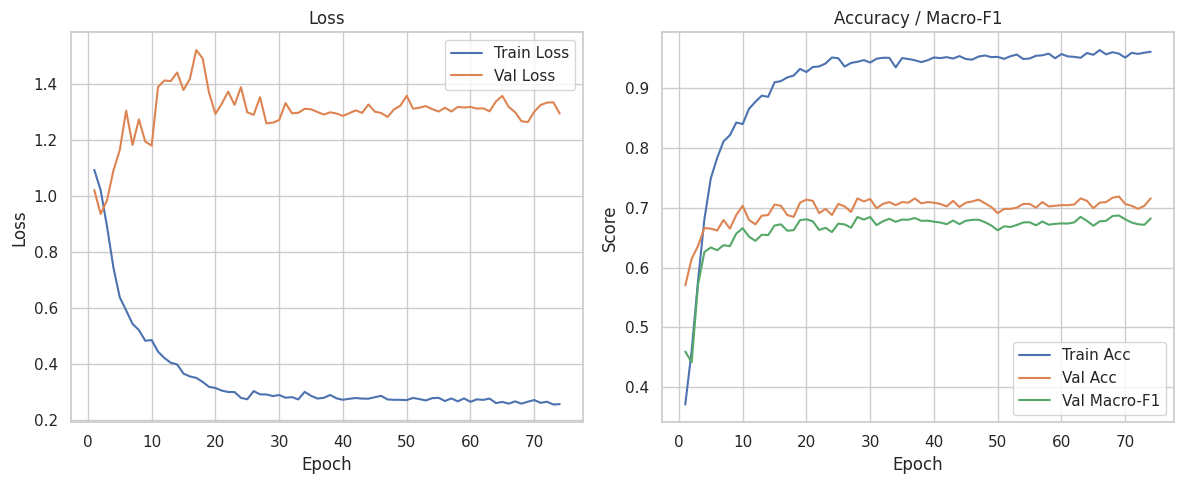

In [52]:
# Plot training curves (if available)
if 'history' in globals() and history is not None:
    plot_results(history)
else:
    print("No training history found. Train the model first (train=True) or load a checkpoint with history.")


# PART FOUR

---

# Part 4 — Detailed Evaluation on the Validation Set

In this section we evaluate the trained model on the **validation** split using standard classification metrics.
Because the task is **3-class** (Negative / Neutral / Positive) and the dataset is **imbalanced**, we report more than accuracy.

**Goal:** compute and report:
- Accuracy
- Precision
- Recall
- F1-score  
and visualize a **Confusion Matrix** with proper class labels.

---

## 4.1 Classification Metrics

### Metrics reported
For the full validation set, we compute:

- **Accuracy**
  $
  \text{Accuracy} = \frac{\#\text{correct predictions}}{\#\text{total samples}}
  $

- **Precision**
  $
  \text{Precision} = \frac{TP}{TP + FP}
  $

- **Recall**
  $
  \text{Recall} = \frac{TP}{TP + FN}
  $

- **F1-score**
  $
  F1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $

### Averaging method
Because this is **multi-class**, we must choose an averaging strategy:

- **Macro average**: average of per-class scores (treats classes equally)
  - best for imbalanced datasets when you care about minority classes

- **Weighted average**: weighted by class support (majority class has more influence)

We have achieved about 0.7 macro-F1.

### Expected output
A printed report containing:
- Accuracy
- Precision (macro or weighted)
- Recall (macro or weighted)
- F1-score (macro or weighted)

---

## 4.2 Confusion Matrix Visualization

### What it shows
A confusion matrix displays how predictions are distributed across true classes:

- Rows = true labels
- Columns = predicted labels

This helps identify:
- which classes are confused (e.g., Positive vs Neutral)
- whether the model collapses to Neutral due to imbalance
- systematic errors in the classifier

### Required labels
The axes must be labeled clearly with:
- **Negative**
- **Neutral**
- **Positive**

### Expected output
- A numeric confusion matrix
- A plotted heatmap-style visualization with labeled axes

---

## Notes & Common Pitfalls

- **Imbalance effect:** high accuracy can hide poor performance on Positive/Negative.
- **Macro vs weighted:** always state which averaging method you used.
- **Use `model.eval()` + `torch.no_grad()`** during evaluation.
- Ensure correct mapping between label indices and class names:
  - `0 → Negative`, `1 → Neutral`, `2 → Positive` (or your chosen mapping)

---

 After finishing Part 4, we have:
- a full metric report (including macro-F1)
- a labeled confusion matrix plot
- insight into which classes the model struggles with most

Evaluation on Validation Set
Accuracy:  0.7186
Precision (weighted): 0.7401
Recall (weighted):    0.7186
F1-score (weighted):  0.7243

Classification Report:
              precision    recall  f1-score   support

    negative       0.56      0.74      0.63       121
     neutral       0.84      0.73      0.78       576
    positive       0.61      0.70      0.65       273

    accuracy                           0.72       970
   macro avg       0.67      0.72      0.69       970
weighted avg       0.74      0.72      0.72       970



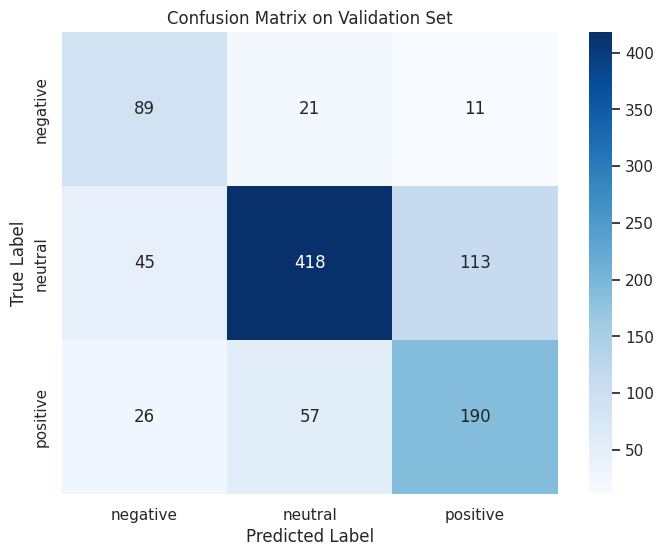


Per-class metrics:
negative   | Precision: 0.5563 | Recall: 0.7355 | F1: 0.6335
neutral    | Precision: 0.8427 | Recall: 0.7257 | F1: 0.7799
positive   | Precision: 0.6051 | Recall: 0.6960 | F1: 0.6474


In [53]:
# PART FOUR: Evaluation on Validation Set
# ----------------------------------------
# This part computes standard classification metrics and confusion matrix
# to evaluate the final model performance on the validation data.

import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []
all_probs = []   # optional: store probabilities if needed

# Disable gradient computation for efficiency
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)          # logits, shape (batch_size, num_classes)
        probs = torch.softmax(outputs, dim=1)               # probabilities (optional)
        preds = torch.argmax(outputs, dim=1)                # predicted class indices

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays for sklearn
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print("Evaluation on Validation Set")
print("============================")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted):    {recall:.4f}")
print(f"F1-score (weighted):  {f1:.4f}")

# Detailed classification report (per class)
target_names = ['negative', 'neutral', 'positive']   # as defined earlier
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Optional: per-class metrics if needed
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
print("\nPer-class metrics:")
for i, name in enumerate(target_names):
    print(f"{name:10} | Precision: {precision_per_class[i]:.4f} | Recall: {recall_per_class[i]:.4f} | F1: {f1_per_class[i]:.4f}")

<font color=3C99D size=5>
Conclusion: </font>

We consider macro F1 more as weighted F1 hides imbalance while macro F1 exposes it.



# PART FIVE

---

# Part 5 — Evaluate on the Test Set & Generate Submission File

In this section we run the trained model on the **unlabeled test set** (provided separately by the course/judge) and generate a `.csv` file containing model predictions.

**Goal:** produce a submission-ready CSV file with one prediction per test sentence.

---

## 5.1 Test-Time Inference

### What we do
1. Load the test data file (sentences only, **no labels**).
2. Apply the same preprocessing and tokenization used during training:
   - BERT tokenizer
   - fixed `MAX_LEN`
   - `input_ids` and `attention_mask`
3. Set model to evaluation mode:
   - `model.eval()`
   - use `torch.no_grad()` to disable gradients
4. Run forward passes and convert logits to predicted labels:
   \[
   \hat{y} = \arg\max(\text{logits})
   \]

### Expected output
A list/array of predicted class indices for all test samples.

---

## 5.2 Create the Submission CSV

### What we do
- Store predictions in a DataFrame.
- Convert label indices to label names if required by the competition format.
- Save as a CSV file (e.g., `submission.csv`).

**Typical formats**
Depending on the judge, submissions are commonly one of these:

**Format A (index + label):**
- `id`, `label`

**Format B (sentence + label):**
- `sentence`, `label`

Your notebook should follow **exactly** the format required by the evaluation system.

### Expected output
- A saved CSV file (e.g., `submission.csv`)
- A preview of the first few rows to verify correctness

---

## Notes & Common Pitfalls

- **Do not shuffle** test data loader if the judge expects original order.
- Make sure the label mapping matches training:
  - `0 → Negative`, `1 → Neutral`, `2 → Positive` (or your mapping)
- Use the same `MAX_LEN`, tokenizer, and preprocessing as training.
- Ensure the CSV contains **only** the required columns and no extra index column (unless required).

---

 After finishing Part 5, we have:
- predictions for the unseen test set
- a correctly formatted `submission.csv` file ready to upload to the judging system

In [54]:
# PART FIVE (Adapted for Validation Set)
# ---------------------------------------
# This part runs the model on the validation set and saves predictions to a CSV file.
# Note: For the actual test submission, you'll need a similar loop but with a test DataLoader.

model.eval()
all_val_preds = []
all_val_labels = []
all_val_sentences = []   # if you want to store the original sentences

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Predicting on validation set"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()   # true labels (already on CPU)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_val_preds.extend(preds)
        all_val_labels.extend(labels)

        # If you want to also save the sentences, you need to access them from the original val_df
        # Since val_loader doesn't directly give sentences, we need to map indices.
        # Alternatively, you can create a separate list of sentences from val_df beforehand.

# Since val_loader shuffles the data, to align sentences with predictions we should either:
# 1. Use a non-shuffled DataLoader for prediction (shuffle=False), or
# 2. Use the original val_df and rely on order (if DataLoader keeps order when shuffle=False).
# By default, your val_loader was created with shuffle=False (I assume), so order is preserved.

# Get the corresponding sentences from val_df
val_sentences = val_df['sentence'].values[:len(all_val_preds)]   # ensure same length

# Convert numeric labels back to original names
true_labels_names = label_encoder.inverse_transform(all_val_labels)
pred_labels_names = label_encoder.inverse_transform(all_val_preds)

# Create DataFrame
results_df = pd.DataFrame({
    'sentence': val_sentences,
    'true_label': true_labels_names,
    'predicted_label': pred_labels_names
})

# Save to CSV
results_df.to_csv('validation_predictions.csv', index=False)
print("Validation predictions saved to 'validation_predictions.csv'")
print(results_df.head())

Predicting on validation set:   0%|          | 0/31 [00:00<?, ?it/s]

Validation predictions saved to 'validation_predictions.csv'
                                            sentence true_label  \
0  Following the payment made in April , the comp...    neutral   
1  The share subscription period for C options wi...    neutral   
2  Aspocomp intends to set up a plant to manufact...    neutral   
3  Finnish Rautaruukki has been awarded a contrac...   positive   
4  Finnish Bank of +àland reports its operating p...   negative   

  predicted_label  
0         neutral  
1         neutral  
2         neutral  
3        positive  
4        negative  


# PART SIX

---

# Part 6 — Visual Output of the Attention Mechanism (15 points)

This section visualizes what the Transformer attends to by extracting and plotting **attention weights** from the **last Transformer layer**.

**Goal:** for at least **5 test sentences**, extract the attention weight matrix and plot it as a **heatmap** to interpret which tokens receive the most attention.

---

## 6.1 Why Attention Visualization?

Self-attention computes how strongly each token attends to other tokens:

$
A = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)
$

Where:
- \(A\) is the attention weight matrix of shape \((T \times T)\)
- \(T\) is the sequence length (after padding/truncation)

A heatmap of \(A\) helps us see:
- which words influence the model’s decision most
- whether sentiment-bearing terms (e.g., *profit*, *loss*, *upgrade*) receive high attention
- patterns like focusing on numbers, negations, or company-specific keywords

---

## 6.2 What We Extract

From the **last layer** of the model:
- attention weights per head: `(num_heads, T, T)`
- optionally averaged across heads: `(T, T)`

We typically visualize either:
- a single head (easier to interpret sometimes), or
- the **mean across heads** (more stable, less noisy)

 For interpretability, averaging across heads is often recommended:
$
A_{\text{avg}} = \frac{1}{H}\sum_{h=1}^{H} A_h
$

---

## 6.3 Heatmap Visualization (Required)

### What we do
For each of the first **5 test sentences**:
1. Tokenize the sentence (`input_ids`, `attention_mask`)
2. Run a forward pass while storing attention weights
3. Convert token IDs back to readable tokens
4. Select the valid tokens (exclude padding)
5. Plot a heatmap where:
   - x-axis = tokens being attended **to**
   - y-axis = tokens attending **from**
   - values = attention weights

### Required labels
The heatmap axes should show the token strings clearly.  
(If tokens are subwords like `##ing`, that is normal for BERT tokenizers.)

---

## Notes & Common Pitfalls

- **Padding:** Always remove padded positions before plotting (otherwise heatmap is dominated by PAD).
- **Model mode:** use `model.eval()` and `torch.no_grad()` for visualization runs.
- **Storage:** attention weights should be stored only when needed (to avoid slowing training).
- **Token limits:** long sentences are truncated to `MAX_LEN`, so the heatmap covers only the first `MAX_LEN` tokens.



In [55]:
# Extract attention weights for the first 5 validation sentences (from the LAST layer)
num_samples = 5
sentences = val_df['sentence'].iloc[:num_samples].values
true_labels = val_df['label_idx'].iloc[:num_samples].values

model.eval()
model.set_store_attention(True)

attention_matrices = []
valid_lengths = []

with torch.no_grad():
    for sent in sentences:
        encoding = tokenizer(
            sent,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(device)
        attn_mask = encoding['attention_mask'].to(device)

        _ = model(input_ids, attn_mask)

        attn_weights = model.layers[-1].attention.last_attention_weights  # (1, H, S, S) on device
        if attn_weights is None:
            raise RuntimeError('Attention weights were not stored. Make sure model.set_store_attention(True) is called.')

        avg_attn = attn_weights.mean(dim=1).squeeze(0).cpu().numpy()  # (S, S)
        attention_matrices.append(avg_attn)

        valid_len = int(attn_mask.squeeze(0).sum().item())
        valid_lengths.append(valid_len)

model.set_store_attention(False)

print(f'Extracted {len(attention_matrices)} attention matrices.')


Extracted 5 attention matrices.


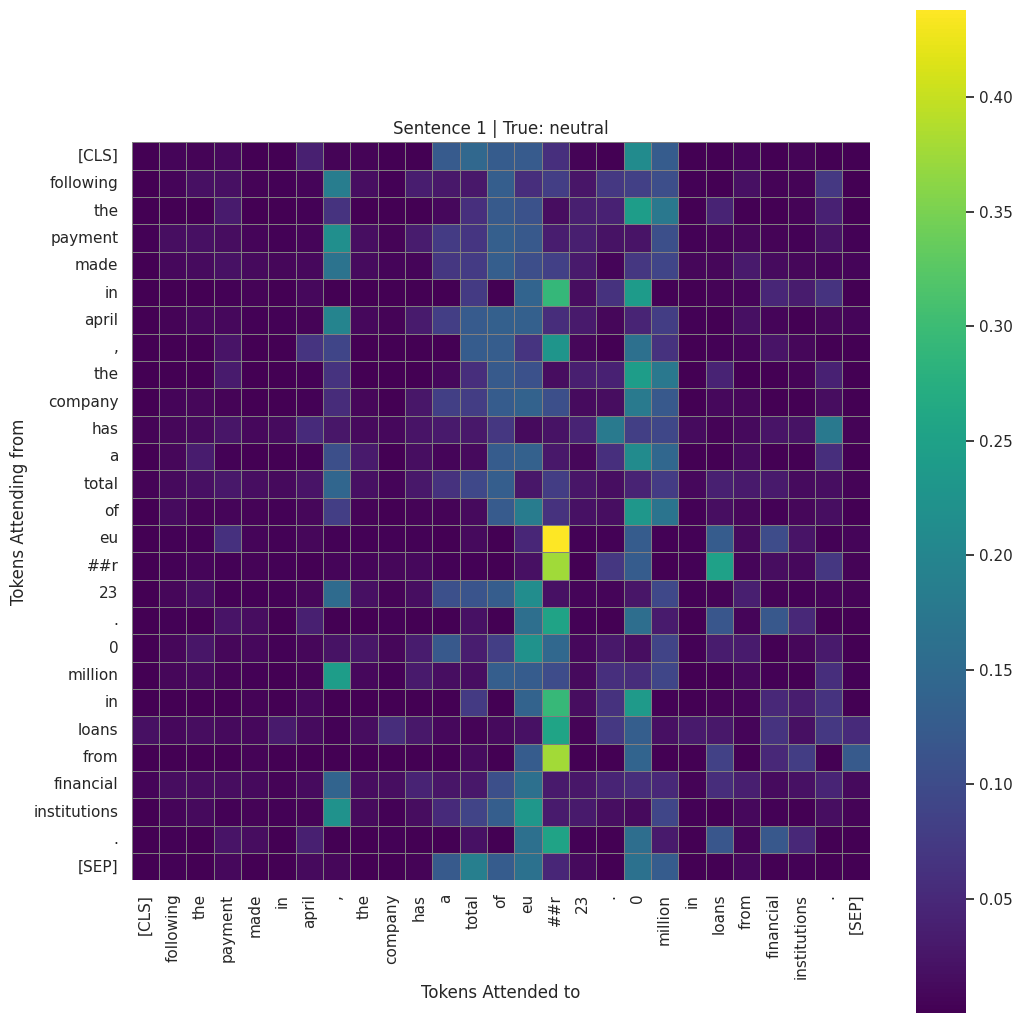

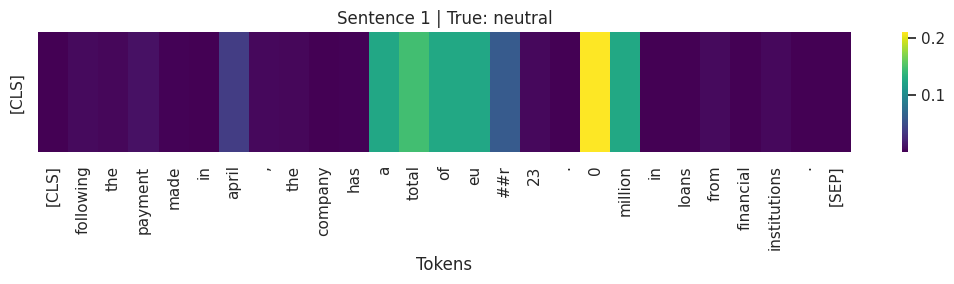

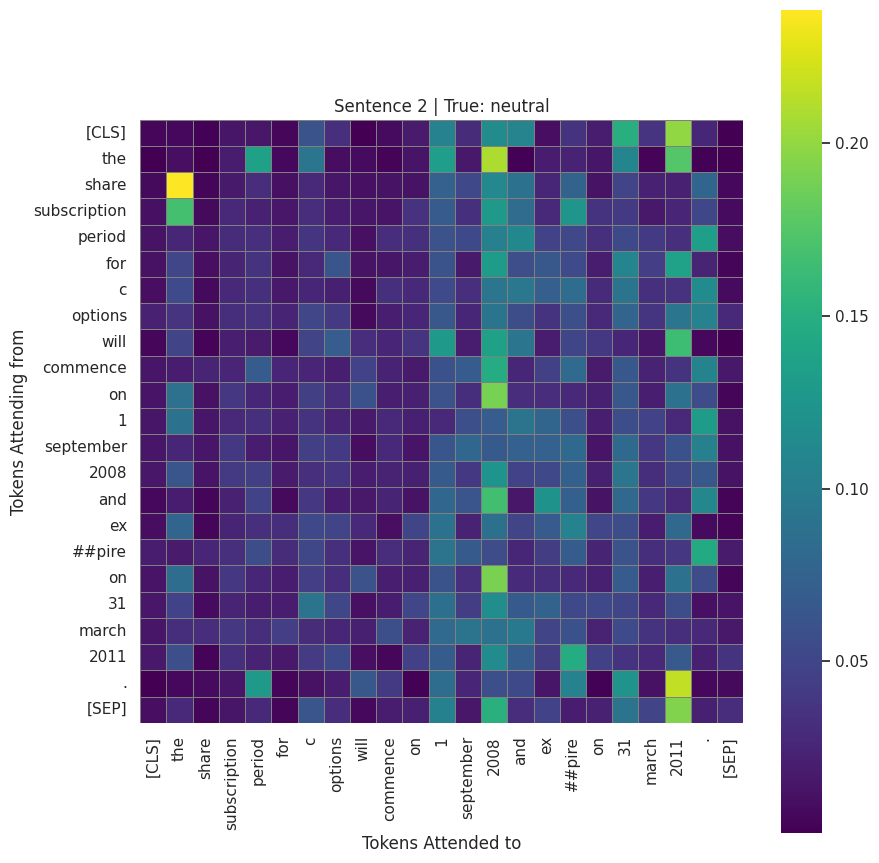

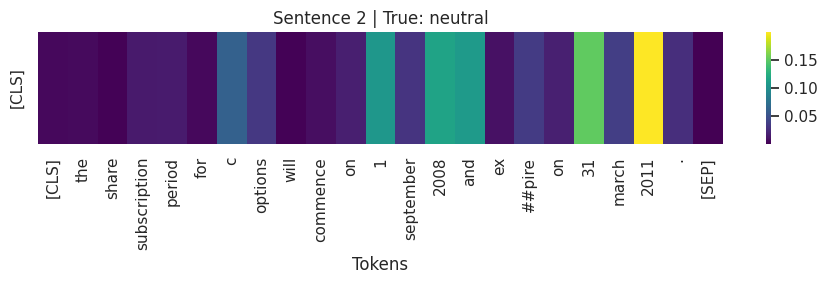

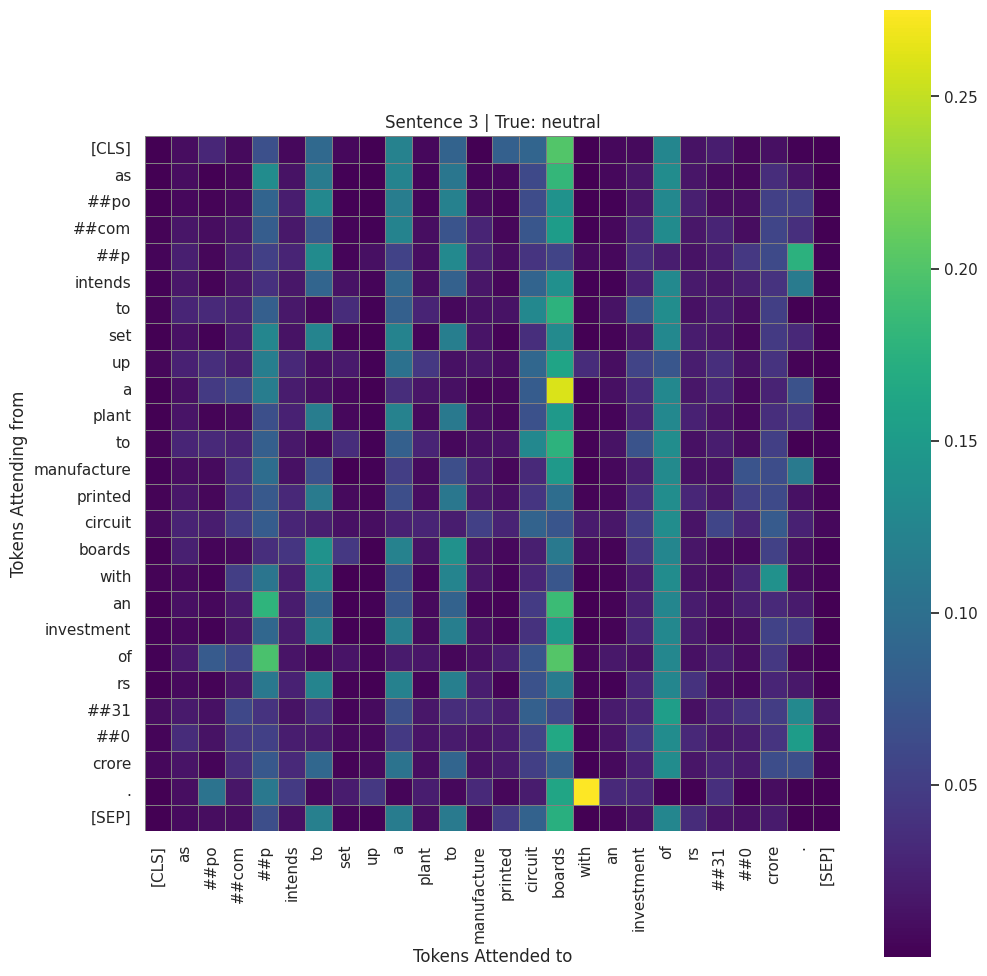

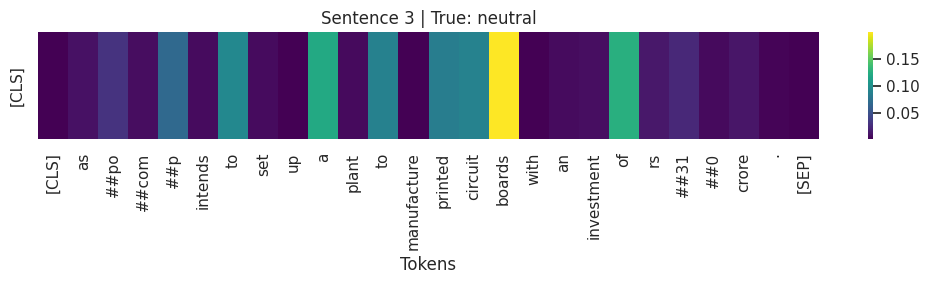

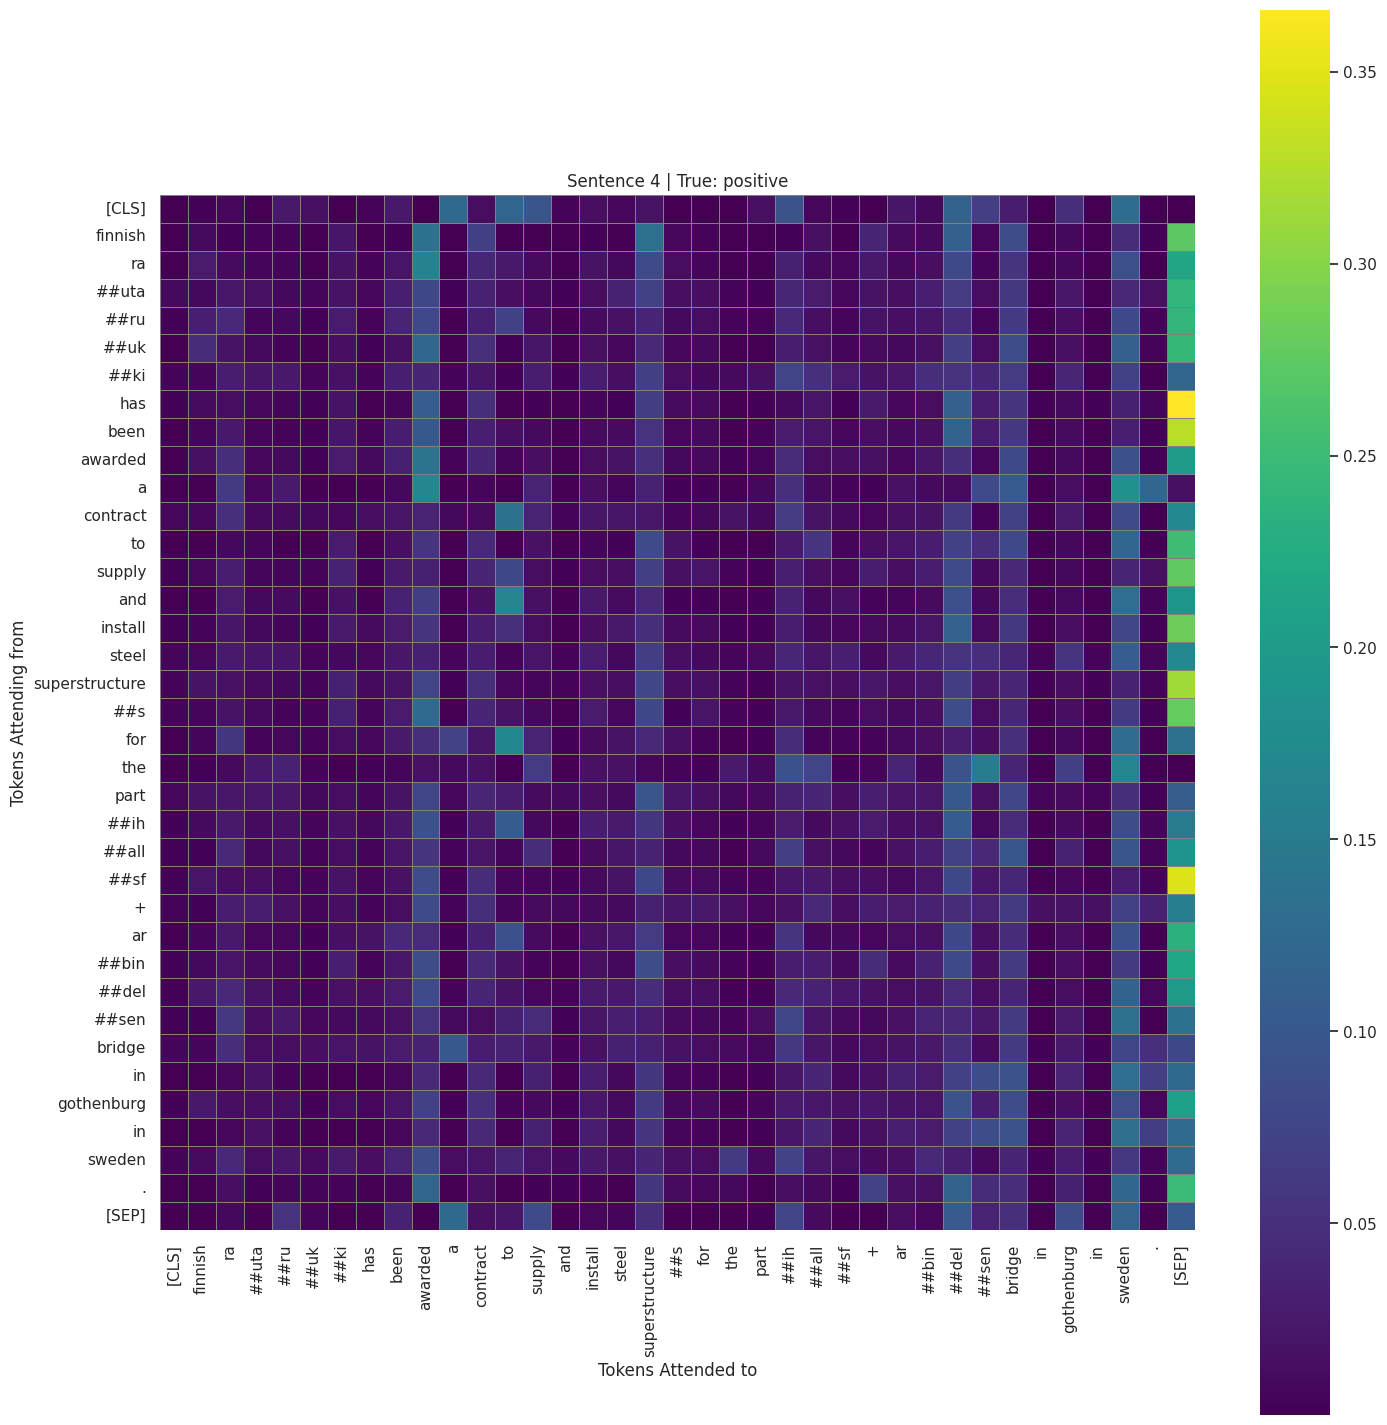

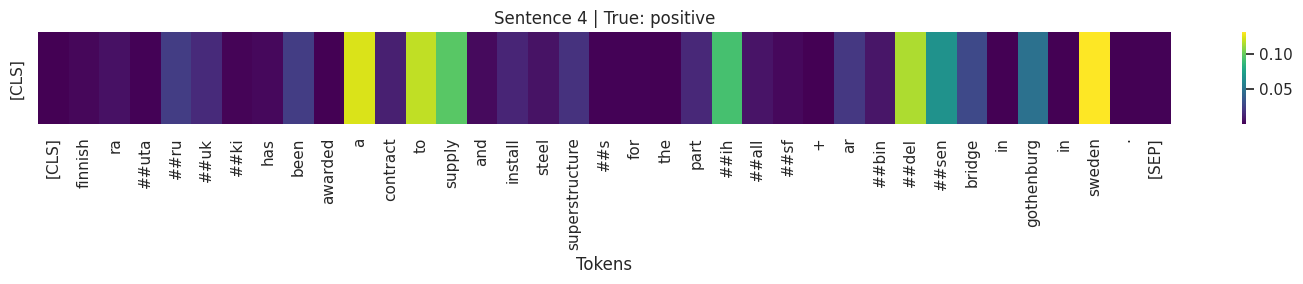

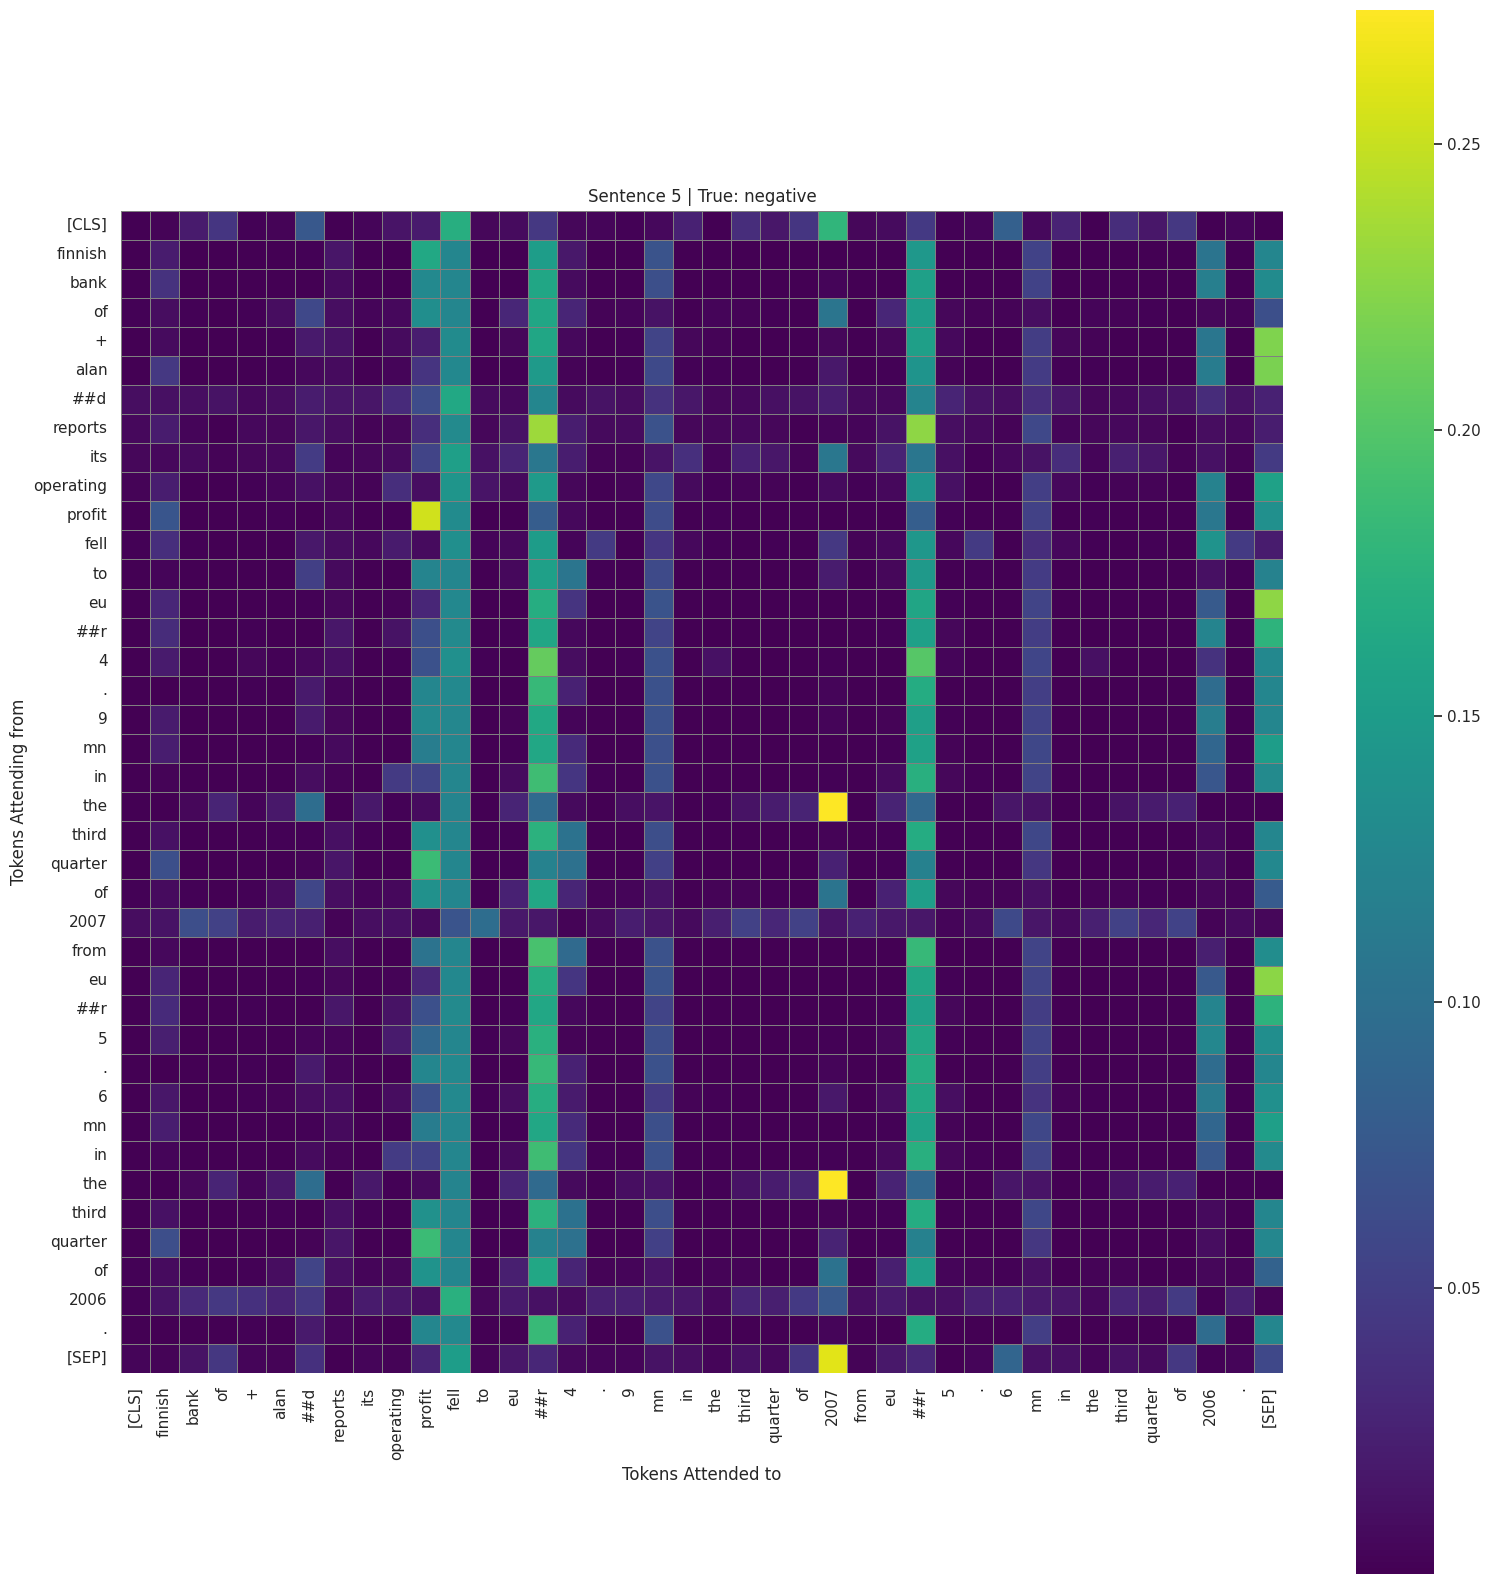

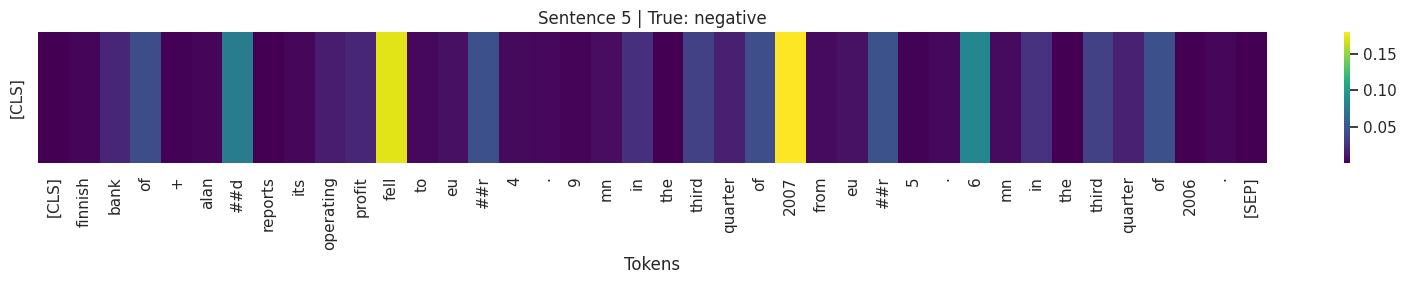

In [56]:
#Plot clean heatmaps (only non-padded tokens)
for i, (sent, attn_matrix, valid_len) in enumerate(zip(sentences, attention_matrices, valid_lengths)):
    # Get token list (including special tokens) without padding
    tokens = tokenizer.tokenize(sent)
    tokens = ['[CLS]'] + tokens + ['[SEP]']  # BERT adds these automatically
    # Truncate if necessary (though we already truncated to MAX_LEN)
    if len(tokens) > valid_len:
        tokens = tokens[:valid_len]

    # Slice the attention matrix to keep only valid rows/columns
    attn_matrix = attn_matrix[:valid_len, :valid_len]

    # True label name
    label_name = label_encoder.inverse_transform([true_labels[i]])[0]

    # Set figure size based on token count (min 8, max 20)
    figsize = max(8, min(20, valid_len * 0.4))
    plt.figure(figsize=(figsize, figsize))

    sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens,
                cmap='viridis', cbar=True, square=True,
                linewidths=0.5, linecolor='gray')  # optional grid lines

    plt.title(f"Sentence {i+1} | True: {label_name}")
    plt.xlabel("Tokens Attended to")
    plt.ylabel("Tokens Attending from")
    plt.tight_layout()
    plt.show()

    cls_attention = attn_matrix[0]  # CLS row

    plt.figure(figsize=(figsize, 3))

    sns.heatmap(
        cls_attention.reshape(1, -1),
        xticklabels=tokens,
        yticklabels=["[CLS]"],
        cmap="viridis",
        cbar=True
    )

    plt.title(f"Sentence {i+1} | True: {label_name}")
    plt.xlabel("Tokens")
    plt.tight_layout()
    plt.show()
